# Исследовательский анализ данных сервиса Яндекс Афиша и проверка гипотез.

- Автор: Прудникова Диана
- Дата: 03.07.2025

## Цели и задачи проекта
**Цель проека**: выявить изменения в пользовательских предпочтениях и популярности событий на сервисе Яндекс Афиша в осенний период 2024 года, а также проверить гипотезы о различиях в поведении пользователей мобильных и стационарных устройств.

**Задачи проекта**:

- Познакомиться с данными;
- Провести предобработку данных;
- Подготовить данные к исследованию;
- Провести исследовательский анализ данных;
- Провести статистический анализ данных - проверить гипотезы;
- Подготовить общие выводы и рекомендации.

## Описание данных

Таблица `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов.
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
- `days_since_prev` -  количество дней с предыдущей покупки для каждого пользователя.

Таблица `final_tickets_events_df.csv` содержит информацию о событиях, а также о площадке проведения мероприятия.
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Дополнительная таблица `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год.
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).


## Содержимое проекта
1. Загрузка данных и знакомство с ними.
2. Предобработка данных и подготовка их к исследованию:
 -  анализ пропусков и категориальных столбцов,
 -  анализ числовых столбцов,
 - проверка дубликатов в объединенном датасете `df_afisha`,
 - преобразование типов данных,
 - создание новых столбцов.
3. Исследовательский анализ данных:
 - анализ распределения заказов по сегментам и их сезонные изменения,
 - сравнение распределения заказов билетов по разным категориям,
 - анализ изменения выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью,
 - анализ осенней активности пользователей: динамика изменений основных показателей по дням, анализ недельной цикличности,
 - анализ популярных регионов и партнёров.
4. Статистический анализ данны: проверка гипотез.
5. Общий вывод и рекомендации.


## 1. Загрузка данных и знакомство с ними.

Загрузим необходимые библиотеки.

In [1]:
# Импортируем библиотеку pandas
import pandas as pd

# Импортируем библиотеку matplotlib.pyplot для визуализации 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # модуль для работы с датами
import seaborn as sns
import statsmodels.api as sm

# Импортируем библиотеку numpy для работы с массивами данных   
import numpy as np

# Импортируем библиотеку scipy для статистического анализа
from scipy import stats
from scipy.stats import mannwhitneyu

# Импорт функции для Z-теста пропорций из библиотеки statsmodels
from statsmodels.stats.proportion import proportions_ztest

Загрузим данные из датасетов `final_tickets_orders_df.csv`, `final_tickets_tenge_df.csv`и дополнительные данные `final_tickets_tenge_df.csv`.

In [2]:
# Выгружаем и сохраняем данные в датафреймы
# Датафрейм с информацией о заказах
df_orders = pd.read_csv("https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv")

# Датафрейм с информацией о событиях
df_events = pd.read_csv("https://code.s3.yandex.net/datasets/final_tickets_events_df.csv")

# Дополнительный датафрейм с информацией о курсе тенге к российскому рублю за 2024 год
df_tenge = pd.read_csv("https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv")

Выведем на экран общую информацию о каждом датасете и первые строки.

In [3]:
# Выводим общую инфорацию о датасетах
display(df_orders.info())
display (df_events.info())
display (df_tenge.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


None

In [4]:
# Выводим первые пять строк датасетов
display(df_orders.head())
display(df_events.head())
display (df_tenge.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


**Вывод**. По первому знакомству данные соответствуют описанию, пропуски наблюдаются в одном столбце `days_since_prev` датафрейма `df_orders`. Это объясняется тем, что здесь хранится информация с количеством дней с предыдущей покупки для каждого пользователя и, если покупки не было, то данные содержат пропуск. В этом случае значения `NaN` можно оставить как есть. 

Таблица `df_orders` содержит 290849 строк и 14 столбцов, `df_events` 22427 строк и 11 стобцов и `df_tenge` 357 строк и 4 столбца. В датасетах с заказами `df_orders` и курсом тенге `df_tenge` типы данных в полях с датой представлены в `object` - в данном случае будет корректно привести их к типу `datetime`. В остальных столбцах типы данных соответствуют содержимому. Также, для экономии памяти и повышения производительности стоит уменьшить разрядность числовых данных: `df_orders['age_limit']`, `df_orders['tickets_count']`, `df_orders['days_since_prev']`.

## Предобработка данных и подготовка их к исследованию.

**Анализ пропусков и категориальных столбцов.** Проверим данные на пропуски - посчитаем абсолютное и относительное значение их числа в столбце` days_since_prev` датафрейма `df_orders`. А также выведим на экран уникальные значения в категориальных данных. 

In [5]:
# Абсолютные и относительные пропуски
df_orders.isnull().sum().sort_values(ascending=False)

round((df_orders.isnull().sum() / df_orders.shape[0]),
      2).sort_values(ascending=False)

days_since_prev          0.08
order_id                 0.00
user_id                  0.00
created_dt_msk           0.00
created_ts_msk           0.00
event_id                 0.00
cinema_circuit           0.00
age_limit                0.00
currency_code            0.00
device_type_canonical    0.00
revenue                  0.00
service_name             0.00
tickets_count            0.00
total                    0.00
dtype: float64

Мы видим, что в поле `days_since_prev` имеется 8% пропусков - это означает, что 8% покупок являются первыми покупками пользователей в рассматриваемом периоде. Далее, проверим уникальные значения в категориальных столбцах датасетов, а также в числовой столбце `tickets_count`.

In [6]:
# Для df_orders

# Проверяем количество уникальных значений
nunique_counts_orders = df_orders.nunique()

display (f'Количество уникальных значений в столбцах')
display (nunique_counts_orders)

# Проверяем уникальные значения
category_columns = ['cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 
                                    'service_name','tickets_count'] 

for column in category_columns:
    if column in df_orders.columns:
        unique_values = df_orders[column].unique()
        display (f'Уникальные значения в {column}:')
        display (unique_values)
        display ('-' * 100) # для читаемости

'Количество уникальных значений в столбцах'

order_id                 290849
user_id                   21940
created_dt_msk              153
created_ts_msk           280986
event_id                  22446
cinema_circuit                6
age_limit                     5
currency_code                 2
device_type_canonical         2
revenue                   42528
service_name                 36
tickets_count                22
total                     55473
days_since_prev             149
dtype: int64

'Уникальные значения в cinema_circuit:'

array(['нет', 'Другое', 'Киномакс', 'КиноСити', 'Москино', 'ЦентрФильм'],
      dtype=object)

'----------------------------------------------------------------------------------------------------'

'Уникальные значения в age_limit:'

array([16,  0, 18, 12,  6], dtype=int64)

'----------------------------------------------------------------------------------------------------'

'Уникальные значения в currency_code:'

array(['rub', 'kzt'], dtype=object)

'----------------------------------------------------------------------------------------------------'

'Уникальные значения в device_type_canonical:'

array(['mobile', 'desktop'], dtype=object)

'----------------------------------------------------------------------------------------------------'

'Уникальные значения в service_name:'

array(['Край билетов', 'Мой билет', 'За билетом!', 'Лови билет!',
       'Билеты без проблем', 'Облачко', 'Лучшие билеты', 'Прачечная',
       'Быстробилет', 'Дом культуры', 'Весь в билетах', 'Билеты в руки',
       'Тебе билет!', 'Show_ticket', 'Городской дом культуры', 'Яблоко',
       'Билет по телефону', 'Выступления.ру', 'Росбилет',
       'Шоу начинается!', 'Мир касс', 'Восьмёрка', 'Телебилет',
       'Crazy ticket!', 'Реестр', 'Быстрый кассир', 'КарандашРУ',
       'Радио ticket', 'Дырокол', 'Вперёд!', 'Кино билет', 'Цвет и билет',
       'Зе Бест!', 'Тех билет', 'Лимоны', 'Билеты в интернете'],
      dtype=object)

'----------------------------------------------------------------------------------------------------'

'Уникальные значения в tickets_count:'

array([ 4,  2,  3,  1,  5,  6, 10,  9,  7, 13, 15, 11,  8, 14, 12, 47, 27,
       17, 19, 57, 30, 37], dtype=int64)

'----------------------------------------------------------------------------------------------------'

In [7]:
# Для df_events 

# Проверяем количество уникальных значений
nunique_counts_events = df_events.nunique()

display (f'Количество уникальных значений в столбцах')
display (nunique_counts_events)

# Проверяем уникальные значения
category_columns_events = ['event_type_description', 'event_type_main',
                        'region_name','city_name', 'venue_name'] 

for column in category_columns_events:
    if column in df_events.columns:
        unique_values_events = df_events[column].unique()
        display (f'Уникальные значения в {column}:')
        display (unique_values_events)
        display ('-' * 100) # для читаемости

'Количество уникальных значений в столбцах'

event_id                  22427
event_name                15248
event_type_description       20
event_type_main               7
organizers                 4293
region_name                  81
city_name                   352
city_id                     353
venue_id                   3225
venue_name                 3217
venue_address              3225
dtype: int64

'Уникальные значения в event_type_description:'

array(['спектакль', 'балет', 'мюзикл', 'опера', 'концерт', 'шоу', 'ёлка',
       'цирковое шоу', 'событие', 'фестиваль', 'спортивное мероприятие',
       'выставка', 'спорт', 'оперетта', 'экскурсия', 'рок-мюзикл',
       'музыкальный спектакль', 'снегурочка', 'подарок',
       'кукольный спектакль'], dtype=object)

'----------------------------------------------------------------------------------------------------'

'Уникальные значения в event_type_main:'

array(['театр', 'концерты', 'ёлки', 'другое', 'стендап', 'выставки',
       'спорт'], dtype=object)

'----------------------------------------------------------------------------------------------------'

'Уникальные значения в region_name:'

array(['Североярская область', 'Светополянский округ',
       'Каменевский регион', 'Лесодальний край', 'Медовская область',
       'Широковская область', 'Тепляковская область', 'Травяная область',
       'Зоринский регион', 'Серебринская область', 'Яблоневская область',
       'Глиногорская область', 'Речиновская область', 'Озернинский край',
       'Горицветская область', 'Солнечнореченская область',
       'Травиницкий округ', 'Солнечноземская область',
       'Ключеводский округ', 'Островная область', 'Луговая область',
       'Каменноозёрный край', 'Лесостепной край', 'Зеленоградский округ',
       'Поленовский край', 'Лугоградская область', 'Синегорский регион',
       'Малиновая область', 'Речицкая область', 'Дальнеземская область',
       'Заречная область', 'Североозёрский округ', 'Дальнезорский край',
       'Малиновоярский округ', 'Сосновская область',
       'Златопольский округ', 'Ягодиновская область',
       'Берестовский округ', 'Золотоключевской край',
       'Каменно

'----------------------------------------------------------------------------------------------------'

'Уникальные значения в city_name:'

array(['Озёрск', 'Глиноград', 'Глиногорск', 'Родниковец', 'Радужсвет',
       'Радужнополье', 'Горнодолинск', 'Родниковск', 'Луговинск',
       'Озёрчане', 'Светополье', 'Теплоозеро', 'Дальнесветск', 'Лесоярич',
       'Островецк', 'Озёрово', 'Сосновечин', 'Ягодиновка', 'Родниковецк',
       'Глинополье', 'Акбасты', 'Лесоводск', 'Синеводов', 'Ордакент',
       'Крутовинск', 'Шаныртау', 'Дальнозолотск', 'Кристалевск',
       'Вишнёво', 'Тихоярск', 'Сарыжар', 'Радужанов', 'Теплоозёрск',
       'Каменевский', 'Островополь', 'Кенесар', 'Рощино', 'Верховино',
       'Сосновогорец', 'Дальнозерск', 'Солчелуг', 'Дальнополин', 'Кумсай',
       'Каменосветск', 'Речинцево', 'Светогория', 'Поленоозёрово',
       'Поляногорье', 'Дальнесоснов', 'Заречиновка', 'Радужнояр',
       'Каменский', 'Речевинец', 'Ордасай', 'Песковино', 'Медовецк',
       'Акбастау', 'Луговаярово', 'Травяниново', 'Каражол', 'Глиногорь',
       'Дальнесветин', 'Горнополец', 'Травогород', 'Серебрянка',
       'Сосноград', 'Мал

'----------------------------------------------------------------------------------------------------'

'Уникальные значения в venue_name:'

array(['Кладбище искусств "Проблема" и партнеры',
       'Лекции по искусству "Свет" Групп', 'Кинокомитет "Золотая" Инк',
       ..., 'Эстрадный театр "Вытяжка" Лимитед',
       'Школа композиции "Окно" Лимитед',
       'Клуб современных танцев "Кофе" Групп'], dtype=object)

'----------------------------------------------------------------------------------------------------'

**Вывод по пропускам.** В результате проверки данных на пропуски, мы выявили, что пробелы в столбце `days_since_prev` датасета с заказами составляют 8%, то есть это процент покупок которые являются первыми покупками пользователей в рассматриваемом периоде. В остальных полях таблиц `df_orders` и `df_events` наличие пропущенных значений не обнаружено. Анализ уникальных значений в категориальных и числовом столбце с количеством билетов в заказе, не выявил индикаторов пропусков.

**Анализ числовых столбцов.** Проанализируем столбец `revenue` с разделением по валютам.

- Для рублей.

count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
25%         113.827500
50%         346.100000
75%         791.700000
90%        1276.150000
95%        1606.500000
99%        2569.594200
max       81174.540000
Name: revenue, dtype: float64

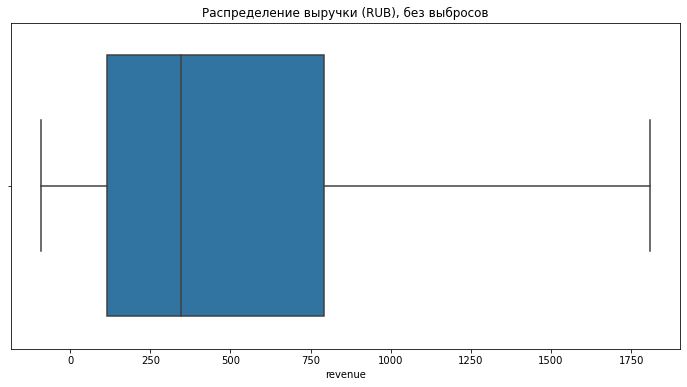

In [8]:
# Фильтруем датасет - оставляем только рубли 
df_rub = df_orders[df_orders['currency_code'] == 'rub']

# Статистики с помощью функции describe
display(df_rub['revenue'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

# Визуализируем с помощью ящика с усами
plt.figure(figsize = (12, 6))
sns.boxplot(x = df_rub['revenue'], showfliers=False) # без выбросов
plt.title('Распределение выручки (RUB), без выбросов')

plt.show()

**Вывод.** Распределение выручки в рублях ассимитричное, сильно скошено вправо, наблюдается большой разброс значений (стандартное отклонение 871.5 руб.). Большая чась заказов (75%) приходится на суммы до 791.7 рубля, при этом медиана составляет 346.1 рублей, что указывает на преобладание небольших покупок. Также, мы видим наличие экстремальных выбросов (максимальное значение 81174.54 руб.). Из всего этого, можно заключить о высокой неоднородности данных. Выявлены отрицательные значения выручки (-90.76 руб.), которые с высокой вероятностью представляют собой ошибки — возможно, это возвраты или ошибки ввода. Такие записи лучше исключить, а также отсечь 1% крупнейших заказов (по 99-му процентилю).

Проверим объем данных, которые содержат аномальные значения - минимальные значения и по 99-му процентилю.

In [9]:
# Подсчитаем строки с revenue <= 0
min_count = (df_rub['revenue'] <= 0).sum()

# Подсчитаем строки выше 99-го процентиля (из оставшихся положительных)
without_zero_lines = df_rub[df_rub['revenue'] > 0]
by_99th_percentile = without_zero_lines['revenue'].quantile(0.99)
size_99 = (without_zero_lines ['revenue'] > by_99th_percentile).sum()

# Общее количество строк
total_size = min_count + size_99 
total_size_percent = (total_size / len (df_rub) *100).round(2)

display (total_size)
display (total_size_percent)

8908

3.12

Количество строк с аномальными значениями в поле `revenue` не критично - 8908 строк (3.12% данных) Исключим эти данные.

In [10]:
# Исключаем минимальные значения
df_rub = df_rub[df_rub['revenue'] > 0] 

# Рассчитываем 99-й процентиль
emissions = df_rub['revenue'].quantile(0.99)

# Фильтруем данные, оставляя только значения ниже 99-го процентиля
df_rub = df_rub[df_rub['revenue'] <= emissions]

# Проверяем максимаьные и минимальные значения после удаления экстремальных значений
display (df_rub['revenue'].max())
display (df_rub['revenue'].min())

2574.32

0.02

Экстремальные значения успешно исключены.

- Для тенге.

count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
90%      13212.930000
95%      13784.260000
99%      17617.240000
max      26425.860000
Name: revenue, dtype: float64

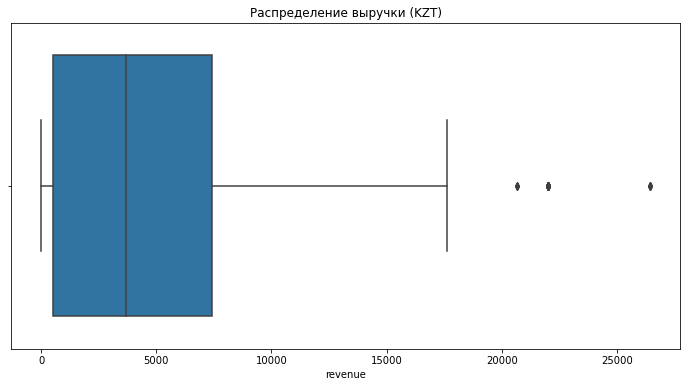

In [11]:
# Фильтруем датасет - оставляем только тенге 
df_kzt = df_orders[df_orders['currency_code'] == 'kzt']

# Статистики с помощью функции describe
display(df_kzt['revenue'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

# Визуализируем с помощью ящика с усами
plt.figure(figsize = (12, 6))
sns.boxplot(x = df_kzt['revenue'])
plt.title('Распределение выручки (KZT)')

plt.show()

**Вывод.** Мы видим, что заказов в тенге всего 5069, что существенно меньше, чем рублевых транзакций (285780). Медиана (3699.8), значительно ниже среднего (4995.2), что указывает на выбросы в большую сторону. Наблюдается плавный рост значений от минимума до 90-го процентиля (min= 0.0, 25% = 518.1, медиана = 3698.8, 75% = 7397.6, 90% = 13212.9). Максимальное значение (26425.8) всего в 1.5 раза превышает 99-й процентиль (17617.2), что говорит об отсутствии экстремальных выбросов. Обнаружены нулевые значения выручки (min = 0), возможно это технические ошибки. В данном случае их лучше удалить.

Перед тем, как исключить нулевые значения выручки, проверим количество данных строк.

In [12]:
# Строки с минимальными значениями < 0
size_min_kzt = len (df_kzt[df_kzt['revenue'] <= 0])

display (size_min_kzt)

6

Всего 6 строк с нулевыми значениями, исключаем их.

In [13]:
# Исключаем минимальные значения
df_kzt = df_kzt[df_kzt['revenue'] > 0] 

# Проверяем минимальные значения после удаления экстремальных значений
display (df_kzt['revenue'].min())

8.67

Экстремальные значения успешно исключены.

Объединим в один датасет очищеные от выбросов таблицы с рублевыми заказами и заказами в тенге.

In [14]:
# Объединяем таблицы сзаказами в разрезе валют в один датасет
clean_orders_df = pd.concat([df_rub, df_kzt], ignore_index=True)

# Выводим первые строки
clean_orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


Далее, проанализируем распределение данных в столбце с количеством билетов в заказе `tickets_count`.

count    281935.000000
mean          2.744125
std           1.156851
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
90%           4.000000
95%           5.000000
99%           6.000000
max          47.000000
Name: tickets_count, dtype: float64

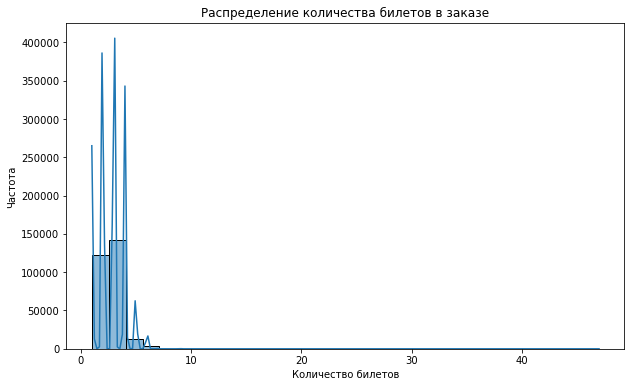

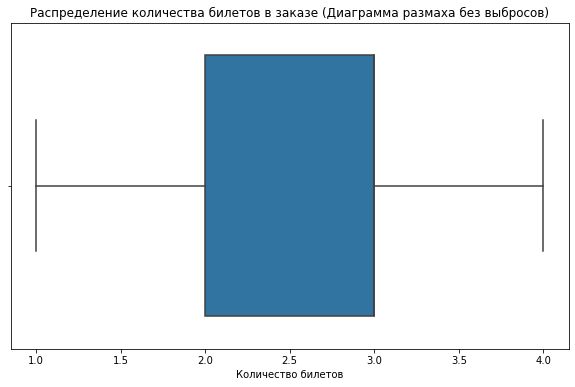

In [15]:
# Статистики по полю tickets_count 
display(clean_orders_df['tickets_count'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))

# Гистограмма распределения
plt.figure(figsize=(10, 6))
sns.histplot(clean_orders_df['tickets_count'], bins=30, kde=True)
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов')
plt.ylabel('Частота')
plt.show()

# Ящик с усами 
plt.figure(figsize=(10, 6))
sns.boxplot(x=clean_orders_df['tickets_count'], showfliers=False) # без выбросов
plt.title('Распределение количества билетов в заказе (Диаграмма размаха без выбросов)')
plt.xlabel('Количество билетов')
plt.show()

**Вывод.** Распределение количества билетов в заказах сильно скошено вправо - мы видим длинный хвост в сторону больших значений. Типичное число билетов заказа от 2 до 3 (медиана = 3, среднее = 2.74), минимальное значение 1, что корректно, так как менее одного билета нельзя купить. Только 1% заказов содержит 6 и более билетов (99 процентиль = 6,) максимальное количество билетов - 47, что допустимо, так как это может быть групповой заказ. 

Мы провели анализ и обработку колличественных значений (в столбце `revenue`), датасета с заказами. Теперь посчитаем сколько удалено данных после обработки.

In [16]:
# Подсчитываем количество удаленных строк в абсолютном и относительном значении
count_row_orders = len(df_orders) - len (clean_orders_df)
percentage_row_orders = round ((100 - (len (clean_orders_df) / len(df_orders)) * 100),2)

display (f"Количество удаленных строк: {count_row_orders},({percentage_row_orders})%")

'Количество удаленных строк: 8914,(3.06)%'

**Всего удалено из таблицы с заказами 8914 строк (3.06)%.** 

Для удобства дальнейшего анализа и обработки данных, объединим датафреймы с заказами и событиями в один - `df_afisha`.

In [17]:
# Объединяем заказы и события по полю event_id
df_afisha = pd.merge(clean_orders_df, df_events, on='event_id',
                        how='left')  # сохраняем все заказы

# Проверяем результат
display(f"Размер объединенного датафрейма: {df_afisha.shape}")
display(df_afisha.head(3))

'Размер объединенного датафрейма: (281935, 24)'

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,...,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,...,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4"
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,...,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6"


Данные успешно объеденены. Проверим сколько заказов не имеют информации о событии.

In [18]:
# Проверим сколько заказов не имеют информации о событии
display (df_afisha.isnull().sum().sort_values(ascending=False))

round((df_afisha.isnull().sum() / df_afisha.shape[0]),
      5).sort_values(ascending=False)

days_since_prev           21383
venue_address                27
venue_name                   27
venue_id                     27
city_id                      27
city_name                    27
region_name                  27
organizers                   27
event_type_main              27
event_type_description       27
event_name                   27
user_id                       0
order_id                      0
tickets_count                 0
service_name                  0
revenue                       0
device_type_canonical         0
currency_code                 0
age_limit                     0
cinema_circuit                0
event_id                      0
created_ts_msk                0
created_dt_msk                0
total                         0
dtype: int64

days_since_prev           0.07584
venue_address             0.00010
venue_name                0.00010
venue_id                  0.00010
city_id                   0.00010
city_name                 0.00010
region_name               0.00010
organizers                0.00010
event_type_main           0.00010
event_type_description    0.00010
event_name                0.00010
user_id                   0.00000
order_id                  0.00000
tickets_count             0.00000
service_name              0.00000
revenue                   0.00000
device_type_canonical     0.00000
currency_code             0.00000
age_limit                 0.00000
cinema_circuit            0.00000
event_id                  0.00000
created_ts_msk            0.00000
created_dt_msk            0.00000
total                     0.00000
dtype: float64

Мы видим, что количество пропусков в информации о событиях некритично (27 строк, 0.0001%), их можно оставить как есть.

**Проверка дубликатов в объединенном датасете `df_afisha`.**

Сохраним исходное количество строк в объединенном датафрейме в переменную `len_df_afisha`. 

In [19]:
# Сохраняем исходное количество строк в объединенном датасете
len_df_afisha = len(df_afisha) 

Проверим явные дубликаты - полные дубликаты строк.

In [20]:
# Проверяем явные дубликаты
duplicates_afisha = df_afisha[df_afisha.duplicated(keep=False)]

display(f"Найдено явных дубликатов: {len(duplicates_afisha)}")

'Найдено явных дубликатов: 0'

Явных дубликатов не выявлено. Проверим наличие неявных дубликатов - это заказы, которые повторяются по всем ключевым данным, кроме `order_id`.

In [21]:
# Создаем список всех столбцов, исключая order_id
dupl_columns = [col for col in df_afisha.columns if col != 'order_id']

# Поиск дубликатов
duplicates_Implicit = df_afisha[df_afisha.duplicated(subset=dupl_columns, keep=False)]
duplicates_Implicit = duplicates_Implicit.sort_values(by=dupl_columns)

display (f"Найдено неявных дубликатов: {len(duplicates_Implicit)}")
display (duplicates_Implicit[dupl_columns].head(10))

'Найдено неявных дубликатов: 56'

,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,...,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
11246,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,...,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50"
11247,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,...,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50"
54822,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,...,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39"
54825,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,...,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39"
80261,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,...,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,событие,выставки,№5015,Нежинская область,Каменёвка,76.0,3094.0,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2"
80266,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,...,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,событие,выставки,№5015,Нежинская область,Каменёвка,76.0,3094.0,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2"
141312,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,Лучшие билеты,...,88478781-0311-42e3-b0ea-d4d6a171b70a,спорт,спорт,№1503,Чистогорская область,Песчанская,21.0,2155.0,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432"
141316,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,Лучшие билеты,...,88478781-0311-42e3-b0ea-d4d6a171b70a,спорт,спорт,№1503,Чистогорская область,Песчанская,21.0,2155.0,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432"
146721,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,Билеты без проблем,...,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,событие,другое,№4403,Североярская область,Озёрск,2.0,2795.0,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482"
146724,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,Билеты без проблем,...,09164a56-0fb3-43c7-91d3-8ed22bb3d8ef,событие,другое,№4403,Североярская область,Озёрск,2.0,2795.0,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482"


Обнаружено 56 дубликатов, это означает, что были созданы полностью идентичные заказы с разными `order_id` - это технический дубликат. Удалим все дубликаты, оставляя первый вариант.

In [22]:
# Удаляем дубликаты по всем столбцам, кроме order_id, оставляя первый вариант
df_afisha = df_afisha.drop_duplicates(subset=dupl_columns, keep='first')

# Число удаленных строк в результате очистки дубликатов
clean_row_dupl = len_df_afisha - len (df_afisha)

display(f"Исходный размер объединенного датасета: {len_df_afisha}, После очистки: {len(df_afisha)}")
display (f"Удалено {clean_row_dupl}, {round ((100 - (len (df_afisha) / len_df_afisha) * 100),2)}%")

'Исходный размер объединенного датасета: 281935, После очистки: 281906'

'Удалено 29, 0.01%'

**Преобразование типов данных.** Приведем столбцы с датой и временем к формату `datetime` и понизим разрядность в числовых столбцах. Также, преобразуем тип данных в поле с датой к `datetime` в дополнительном датафрейме с курсом тенге `df_tenge`.

In [23]:
# Приводим столбцы с датой в формат datetime
df_afisha ['created_dt_msk'] = pd.to_datetime(df_afisha ['created_dt_msk'])
df_afisha ['created_ts_msk'] = pd.to_datetime(df_afisha ['created_ts_msk'])
df_tenge ['data'] = pd.to_datetime(df_tenge ['data'])

# Оптимизируем разрядность числовых столбцов int
int_columns = ['age_limit', 'tickets_count', 'order_id', 'event_id'] # Список для int

for column in int_columns:
    if column in df_afisha.columns:
        df_afisha[column] = pd.to_numeric(df_afisha[column], downcast='integer')
        
        
# Оптимизируем разрядность числовых столбцов float
float_columns = ['revenue', 'days_since_prev', 'city_id', 'venue_id'] # Список для float

for column in float_columns:
    if column in df_afisha.columns:
        df_afisha[column] = pd.to_numeric(df_afisha[column], downcast='float')

После преобразования проверяем типы данных в основном датафрейме `df_afisha` и дополнительном `df_tenge`.

In [24]:
# Основной датафрейм df_afisha 
display(df_afisha.dtypes)

# Дополнительный датафрейм df_tenge
display(df_tenge.dtypes)

order_id                           int32
user_id                           object
created_dt_msk            datetime64[ns]
created_ts_msk            datetime64[ns]
event_id                           int32
cinema_circuit                    object
age_limit                           int8
currency_code                     object
device_type_canonical             object
revenue                          float32
service_name                      object
tickets_count                       int8
total                            float64
days_since_prev                  float32
event_name                        object
event_type_description            object
event_type_main                   object
organizers                        object
region_name                       object
city_name                         object
city_id                          float32
venue_id                         float32
venue_name                        object
venue_address                     object
dtype: object

data       datetime64[ns]
nominal             int64
curs              float64
cdx                object
dtype: object

Типы данных преобразованы успешно.

**Создание новых столбцов.** Далее, создадим несколько новых столбцов:
- `revenue_rub` — конвертируем выручку с заказа к единой валюте — российскому рублю. Для этого будем использовать датафрейм с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год. 
- `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие.
- `month` — месяц оформления заказа.
- `season` — информация о сезонности, включает такие категории, как: `лето`, `осень`, `зима`, `весна`. 

Конвертируем выручку в рубли.

In [25]:
# Объединяем основной датасет df_afisha с  курсом тенге df_tenge
df_afisha = pd.merge(df_afisha, df_tenge,left_on='created_dt_msk',
                                              right_on='data',how='left')
df_afisha.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,100,18.5010,kzt
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,100,19.6648,kzt


Объединение прошло успешно. Далее, конвертируем поле `revenue` в рубли.

In [26]:
# Конвертируем revenue в рубли
def convert_currency(row):
    """
    Функция на вход принимает один аргумент - строку row,
    если валюта 'kzt', то производится вычисление по формуле: revenue * (curs / nominal)
    Для остальных заказов в рублях, выручка остается неизменной.
    """
    if row['currency_code'] == 'kzt':
        return row['revenue'] * (row['curs'] / row['nominal'])
    return row['revenue']


# Применяем функцию к каждой строке
df_afisha['revenue_rub'] = df_afisha.apply(convert_currency, axis=1)

# Проверяем результат
display (f"Успешно обработано: {df_afisha['revenue_rub'].notna().sum()} строк из {len(df_afisha)} строк с суммой выручки")

'Успешно обработано: 281906 строк из 281906 строк с суммой выручки'

Конвертация прошла успешно. Далее, удалим временные столбцы из датасета `df_tenge`.

In [27]:
# Удаляем временные столбцы
# Удаляем указанные столбцы из датафрейма
df_afisha.drop(columns=['data', 'curs', 'nominal', 'cdx'], 
                                     inplace=True, errors='ignore')
# Проверяем результат
display(f"Оставшиеся столбцы: {list(df_afisha.columns)}")
display(df_afisha.head())

"Оставшиеся столбцы: ['order_id', 'user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev', 'event_name', 'event_type_description', 'event_type_main', 'organizers', 'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name', 'venue_address', 'revenue_rub']"

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,...,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1521.939941
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.450012,...,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",289.450012
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.569946,...,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",1258.569946
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.490000,...,выставка,другое,№5049,Североярская область,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",8.490000
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.410034,...,шоу,стендап,№832,Озернинский край,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",1390.410034


Далее, посчитаем выручку с продажи одного билета на мероприятие и сохраним данные в столбец `one_ticket_revenue_rub`, а также выделим месяц оформления заказа `month` и создадим категориальный столбец `season` c информацию о сезонности.  

In [28]:
# Считаем выручку с одного билета
df_afisha ['one_ticket_revenue_rub'] = df_afisha ['revenue_rub'] / df_afisha ['tickets_count']


# Выделяем месяц оформления заказа
df_afisha ['month'] = df_afisha ['created_dt_msk'].dt.month


# Функция для категоризации по сезонам
def categorize(number_month):
    ''' Функция определяет к какому сезону отнести номер месяца,
     на вход принимает один аргумент number_month - номер месяца
     '''
    if  number_month == 12 or 1 <= number_month < 3:
        return 'зима'
    elif number_month >=3 and number_month < 6:
        return 'весна'
    elif number_month >=6 and number_month < 9:
        return 'лето'
    elif number_month >=9 and number_month < 12:
        return 'осень'

# Проверим корректность рабок данным.ты функции categorize
test = pd.DataFrame({'month': range(1, 13)})
test['season'] = test['month'].apply(categorize)
display(test)

,month,season
0,1,зима
1,2,зима
2,3,весна
3,4,весна
4,5,весна
5,6,лето
6,7,лето
7,8,лето
8,9,осень
9,10,осень


Функция для определения сезона работает корректно, применим ее к нашим данным. 

In [29]:
# Применяем функцию к данным
df_afisha ['season'] = df_afisha['month'].apply(categorize)

# Проверяем результат
display(df_afisha[['revenue_rub', 'one_ticket_revenue_rub', 'month', 'season']].head())

,revenue_rub,one_ticket_revenue_rub,month,season
0,1521.939941,380.484985,8,лето
1,289.450012,144.725006,7,лето
2,1258.569946,314.642487,10,осень
3,8.490000,4.245000,7,лето
4,1390.410034,463.470011,10,осень


Необходимые столбцы добавлены. 

В результате предобработки подготовлен итоговый датафрейм `df_afisha`. Посчитаем сколько всего данных было отфильтровано. 

In [30]:
# Сколько всего данных было отфильтровано

# Изначальный объём данных
len(df_orders) 

# Объем удаленных данных после обработки выбросов столбца revenue
count_row_orders

# Объем удаленных данных в результате очистки дубликатов
clean_row_dupl

# Итоговый объем удаленных данных
total_clean = count_row_orders + clean_row_dupl 

display(f"Исходный размер данных: {len(df_orders)}, После очистки: {len(df_afisha)}")
display (f"Удалено {total_clean}, {round ((total_clean/len(df_afisha))*100,2)}%")

'Исходный размер данных: 290849, После очистки: 281906'

'Удалено 8943, 3.17%'

**Вывод по предобработке данных.** 

В процессе подготовки данных к исследованию, были проведены следующие действия:
- `анализ пропусков и категориальных столбцов.` Мы обнаружили пропуски в столбце `days_since_prev` (8%), это не является ошибкой, а означает, что это доля покупок, которые являются первыми покупками пользователей в рассматриваемом периоде. Изучение уникальных значений в категориальных столбцах не выявело пропуски-индикаторы. 
- `исследование и обработка числовых столбцов.` Анализ выявил значительную неоднородность в данных о выручке (`revenue`). В рублевых заказах распределение сильно скошено вправо, с большим разбросом значений (стандартное отклонение 871.5 руб.), что указывает на преобладание небольших покупок (медиана 346.1 руб.), при наличии экстремальных выбросов (максимум 81 174.54 руб.). Обнаружены отрицательные значения выручки, вероятно, связанные с возвратами или ошибками ввода. Для повышения качества данных мы исключили записи с отрицательной выручкой и отсекли 1% крупнейших заказов (по 99-му процентилю). В заказах в тенге ситуация более стабильна: медиана (3 699.8 тенге) близка к среднему (4 995.2 тенге), а максимальное значение (26 425.8 тенге) лишь в 1.5 раза превышает 99-й процентиль, что говорит об отсутствии экстремальных выбросов. Однако нулевые значения выручки, вероятно, являются техническими ошибками и были исключены. После очистки данных от выбросов в столбце `revenue` отфильтрованный датафрейм с заказами был объединён с информацией о событиях. Количество пропусков в данных о событиях минимально (27 строк, 0.0001%), поэтому их оставили без изменений.
- `анализ и обработка явных и неявных дубликатов.` Явных дубликатов не обнаружно, однако выявлено 56 идентичных заказов с разными order_id - это технический дубликат, и данные строки были исключены, оставляя первый эксземпляр.
- `преобразование типов данных.` Столбцы `created_dt_msk`, `created_dt_msk` и `data` из дополнительного датафрейма `df_tenge` были приведены к корректному типу даты и времени `datetime`, атакже оптимизировали разрядность числовых столбцов.
- `создание новых столбцов`: `revenue_rub` - выручка с заказа в рублях, `one_ticket_revenue_rub` — выручка с продажи одного билета на мероприятие, `month` — месяц оформления заказа, `season` — информация о сезонности, включает такие категории, как: лето, осень, зима, весна.

В итоге было удалено 8943 строки из 290849 - это  3.17% данных.

Для дальнейшего исследовательского анализа подготовлен единый датафрейм - `df_afisha`, хранящий информацию о заказах и событиях сервиса `Яндекс Афиша`.

## Исследовательский анализ данных.

**Анализ распределения заказов по сегментам и их сезонные изменения.**

Изучим общую сезонную динамику - для каждого месяца найдем количество заказов.

In [31]:
# Группируем по месяцам и находим количество заказов для каждого месяца
orders_month = df_afisha.groupby('month',as_index=False)['order_id'].count().sort_values(
                                                                     by='order_id',ascending=False)
display (orders_month)

,month,order_id
4,10,99013
3,9,68894
2,8,43176
1,7,37890
0,6,32933


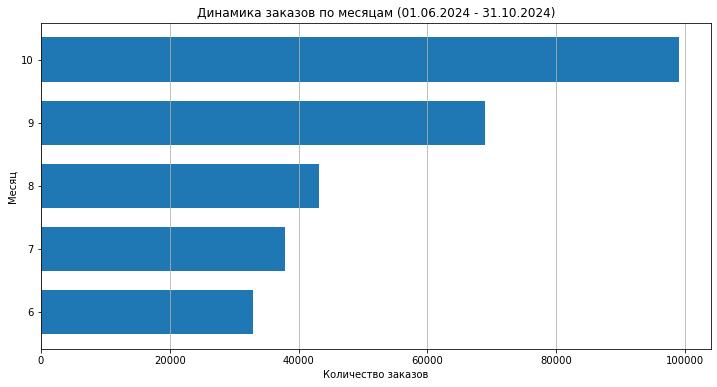

In [32]:
# Визуализируем на линейчатой диаграмме
orders_month_on_the_diagram = df_afisha.groupby('month', as_index=False)['order_id'].count()\
                       .sort_values('order_id', ascending=True)

# Задаем размер графика
plt.figure(figsize=(12, 6))

# Строим горизонтальную диаграмму
plt.barh(orders_month_on_the_diagram['month'],
    orders_month_on_the_diagram['order_id'], height=0.7)
 
# Настраиваем внешний вид диаграммы
plt.title('Динамика заказов по месяцам (01.06.2024 - 31.10.2024)')
plt.xlabel('Количество заказов')
plt.ylabel('Месяц')
plt.xticks(rotation=0)
plt.grid(b=True, axis='x') 

# Выводим на экран
plt.show()

**Вывод.** Наблюдается рост числа заказов от летних к осенним месяцам - максимальное значение в октябре (99013), что в 3 раза выше, чем в июне (32933). В целом, летние месяцы (июнь-август) демонстрируют более низкие показатели, чем осенние (сентябрь-октябрь) - резкий рост начинается в сентябре (август 43176, сентябрь 68894), это составляет +59.6% к августу.

**Далее, для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям:** 
- тип мероприятия, 
- тип устройства,
- категория мероприятия по возрастному рейтингу. 

Распределение заказов билетов по типу мероприятия.

In [33]:
# Доли по типу мероприятия
summer_season = df_afisha[df_afisha['season'] == 'лето']['event_type_main'].value_counts(
                                                                   normalize=True).mul(100).round(1)
autumn_season = df_afisha[df_afisha['season'] == 'осень']['event_type_main'].value_counts(
                                                                   normalize=True).mul(100).round(1)

display (f'Доля заказов по типу мероприятия в летний период (%)')
display (summer_season)

display (f'Доля заказов по типу мероприятия в осенний период (%)')
display (autumn_season)

'Доля заказов по типу мероприятия в летний период (%)'

концерты    43.9
другое      25.0
театр       20.8
стендап      5.6
спорт        2.4
выставки     2.1
ёлки         0.2
Name: event_type_main, dtype: float64

'Доля заказов по типу мероприятия в осенний период (%)'

концерты    37.4
театр       25.4
другое      19.5
спорт       11.2
стендап      4.1
выставки     1.4
ёлки         1.0
Name: event_type_main, dtype: float64

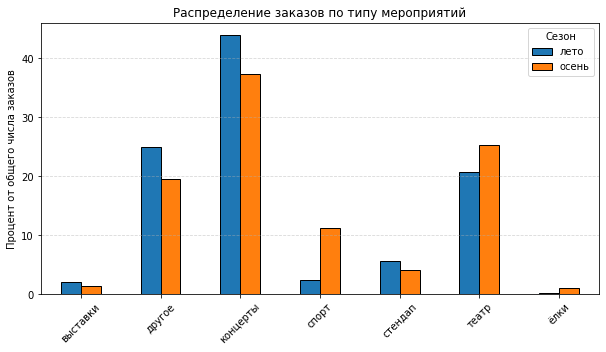

In [34]:
# Визуализируем в виде столбчатой диаграммы

# Создаем датафрейм с долями количества заказов в разрезе сезонов по типу мероприятий
season_type_main= pd.DataFrame({'лето': summer_season, 'осень': autumn_season})

# Строим столбчатую диаграмму
season_type_main.plot(kind='bar', edgecolor='black', figsize=(10, 5))

# Настраиваем внешний вид диаграммы
plt.title('Распределение заказов по типу мероприятий')
plt.ylabel('Процент от общего числа заказов')
plt.legend(title='Сезон')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

# Выводим на экран
plt.show()

**Вывод.** Мы видим, что концерты лидируют в оба сезона, но их доля больше летом (с 43.9% до 37.4%), а театры и спортивные события существенно набирают популярность осенью (театр с 20.8% до 25.4%, спортивные события с 2.4% до 11.2%). В целом, можно заключить, что летом более популярны развлекательные мероприятия (концерты 43.9%, стендап 5.6%), а осенью культурные (театры 25.4 %) и спортивные (11.2%), а также начинают появляться зимние тематики (ёлки 0.2%).

Распределение заказов билетов по типу устройства.

In [35]:
# Доли по типу устройства
summer_season_device = df_afisha[df_afisha['season'] == 'лето']['device_type_canonical'].value_counts(
                                                                   normalize=True).mul(100).round(1)
autumn_season_device = df_afisha[df_afisha['season'] == 'осень']['device_type_canonical'].value_counts(
                                                                   normalize=True).mul(100).round(1)

display (f'Доля заказов по типу устройства в летний период (%)')
display (summer_season_device)

display (f'Доля заказов по типу устройства в осенний период (%)')
display (autumn_season_device)

'Доля заказов по типу устройства в летний период (%)'

mobile     80.9
desktop    19.1
Name: device_type_canonical, dtype: float64

'Доля заказов по типу устройства в осенний период (%)'

mobile     79.6
desktop    20.4
Name: device_type_canonical, dtype: float64

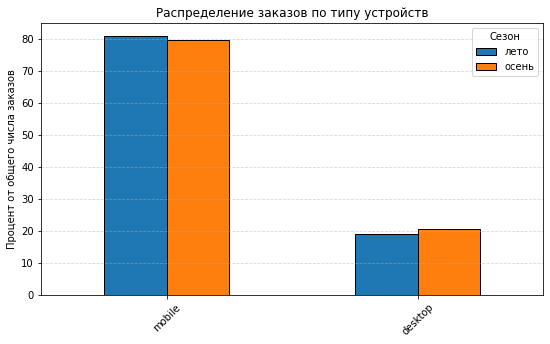

In [36]:
# Визуализируем в виде столбчатой диаграммы

# Создаем датафрейм с долями количества заказов в разрезе сезонов по типу устройств
season_type_device = pd.DataFrame({'лето': summer_season_device, 'осень': autumn_season_device})

# Строим столбчатую диаграмму
season_type_device.plot(kind='bar', edgecolor='black', figsize=(9, 5))

# Настраиваем внешний вид диаграммы
plt.title('Распределение заказов по типу устройств')
plt.ylabel('Процент от общего числа заказов')
plt.legend(title='Сезон')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

# Выводим на экран
plt.show()

**Вывод.** Мы видим, что в оба сезона подавляющее большинство заказов (летом 80.9%, осенью 79.6), совершается с мобильных устройств, происходит небольшое снижение заказов с данного типа устройств осенью (на 1.3 п.п.). Незначительное увеличении доли десктопов осенью (летом 19.1%, осенью 20.4%), может быть по некоторым причинам, например в связи с более сложными покупками (групповые билеты), или из-за рабочего сезона (покупки с рабочих компьютеров).

Распределение заказов билетов по возрастному рейтингу.

In [37]:
# Доли по  возрастному рейтингу
summer_season_age = df_afisha[df_afisha['season'] == 'лето']['age_limit'].value_counts(
                                                                   normalize=True).mul(100).round(1)
autumn_season_age = df_afisha[df_afisha['season'] == 'осень']['age_limit'].value_counts(
                                                                   normalize=True).mul(100).round(1)

display (f'Доля заказов по возрастному рейтингу в летний период (%)')
display (summer_season_age)

display (f'Доля заказов по возрастному рейтингу в осенний период (%)')
display (autumn_season_age)

'Доля заказов по возрастному рейтингу в летний период (%)'

16    28.4
12    21.3
6     18.3
0     18.1
18    13.9
Name: age_limit, dtype: float64

'Доля заказов по возрастному рейтингу в осенний период (%)'

16    26.3
0     23.4
12    22.2
6     17.7
18    10.4
Name: age_limit, dtype: float64

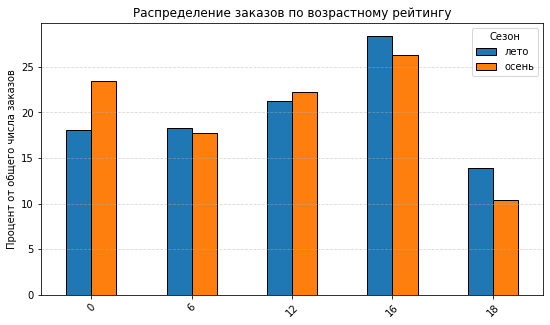

In [38]:
# Визуализируем в виде столбчатой диаграммы

# Создаем датафрейм с долями количества заказов в разрезе сезонов по возрастному рейтингу
season_type_age = pd.DataFrame({'лето': summer_season_age, 'осень': autumn_season_age})

# Строим столбчатую диаграмму
season_type_age.plot(kind='bar', edgecolor='black', figsize=(9, 5))

# Настраиваем внешний вид диаграммы
plt.title('Распределение заказов по возрастному рейтингу')
plt.ylabel('Процент от общего числа заказов')
plt.legend(title='Сезон')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

# Выводим на экран
plt.show()

**Вывод.** Мы видим, что возрастная категория 16+ сохраняет лидерство в оба сезона (летом 28.4% летом, осенью 26.3%). В осенний период наблюдается рост спроса на мероприятия 0+ (с 18.1% летом до 23.4% осенью) и снижение доли мероприятий 18+ (с 13.9% летом до 10.4% осенью). Заметно, что летом преобладают мероприятия для подростков (первое и второе место в рейтинге 16+ 28.4% и 12+ 21.3%), а осенью увеличивается доля семейных мероприятий (первое и второе место в рейтинге 0+ 23.4% и 6+ 17.7%). 

**Далее, изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.**

In [39]:
# Посчитаем среднюю выручку с одного билета
avg_ticket_revenue = df_afisha.groupby(['season', 'event_type_main']
                                      )['one_ticket_revenue_rub'].mean()

# Рассчитываем относительное изменение
ticket_revenue_change = (((avg_ticket_revenue.loc['осень'] - avg_ticket_revenue.loc['лето']) / 
                         avg_ticket_revenue.loc['лето']) * 100).round(2)


display(f'Изменение средней выручки с одного билета осенью относительно лета (%)')
display(ticket_revenue_change)

'Изменение средней выручки с одного билета осенью относительно лета (%)'

event_type_main
выставки     5.95
другое     -12.04
концерты   -13.37
спорт       -9.05
стендап      5.77
театр      -18.62
ёлки       -15.28
Name: one_ticket_revenue_rub, dtype: float64

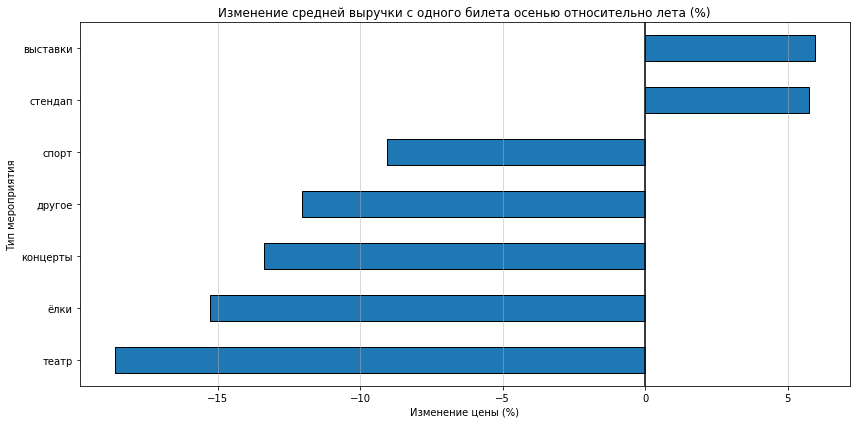

In [40]:
# Задаем размер графика
plt.figure(figsize=(12, 6))

# Строим линейчатую диаграмму 
ticket_revenue_change.sort_values().plot(kind='barh', edgecolor='black')  

# Настраиваем внешний вид диаграммы
plt.title('Изменение средней выручки с одного билета осенью относительно лета (%)')
plt.xlabel('Изменение цены (%)')
plt.ylabel('Тип мероприятия')
plt.axvline(0, color='black')
plt.grid(axis='x', alpha=0.6)
plt.tight_layout()

# Выводим на экран
plt.show()

**Вывод.** Наблюдается снижение средней стоимости билетов осенью для большинства категорий мероприятий (максимально падение театры -18.62%, ёлки - 15.28%, концерты - 13.37%), исключение составляют выставки (+5.95%) и стендап (+5.77%). Снижение цен на такие категории, как театр, концерт и елки, может быть связано, например с увеличением предложений осенью.

**Вывод о распределении заказов по сегментам и их сезонных изменениях.** Мы наблюдаем, что с наступлением осени происходит перераспределение спроса от концертов к театрам и выставкам. При этом концерты сохраняют лидерство по популярности, но теряют 6.5 процентных пунктов (летняя доля  43.9%, осенняя доля 37.4%). Театр и спортивные события демонстрируют рост (театр с 20.8% до 25.4% +4.6 п.п., спортивные события с 2.4% до 11.2% +8.8 п.п.).

Мобильные устройства сохраняют лидерство (летом 80.9%, осенью 79.6%), незначительный рост десктопных покупок осенью (летом 19.1%, осенью 20.4% +1.3 п.п.), говорит об увеличении групповых покупок.

По возрастной категории осенью происходит увеличение доли семейных мероприятий (0+ летом 18.1%, осенью 23.4%) на 5.3 п.п., снижается спрос на контент 18+ (13.9% летом, 10.4% осенью), а подростковая аудитория (12+, 16+) остается стабильной (летом 16+ 28.4% , 12+ 21.3%; осенью 16+ 26.3%, 12+ 22.2%). 

В осенний период изменение средней стоимости одного билета имеет тенденцию к снижению у большинства типов мероприятий: театры -18.62%, ёлки - 15.28%, концерты - 13.37%, но некоторые нишевые форматы - выставки и стендап, демонстрируют рост стоимости (выставки 5.95%, стендап 5.77%).

**Осенняя активность пользователей.**

**Динамика изменений основных показателей по дням.** 

Проанализируем динамику изменений по дням для:
- общего числа заказов;
- количества активных пользователей DAU;
- среднего числа заказов на одного пользователя;
- средней стоимости одного билета.

In [41]:
# Фильтруем осенние месяцы (сентябрь-октябрь)
autumn_afisha = df_afisha[(df_afisha['created_dt_msk'].dt.month.isin([9,10]))]

# Создаем сводную таблицу
summary_table_activity = autumn_afisha.groupby('created_dt_msk').agg(
    total_orders=('order_id', 'count'), # Общее число заказов
    dau=('user_id', 'nunique'), # Количество активных пользователей в день    
    avg_ticket_cost=('one_ticket_revenue_rub', 'mean') # Средняя стоимость одного билета
).reset_index()

# Рассчитываем заказы на пользователя
summary_table_activity['avg_order_per_user'] = summary_table_activity['total_orders'
                                                            ]/summary_table_activity['dau']

# Выводим все строки 
print(summary_table_activity.to_string())

   created_dt_msk  total_orders   dau  avg_ticket_cost  avg_order_per_user
0      2024-09-01          1314   555       202.149068            2.367568
1      2024-09-02          1370   571       190.847823            2.399299
2      2024-09-03          5090   776        80.713513            6.559278
3      2024-09-04          1758   684       179.567815            2.570175
4      2024-09-05          1940   738       189.902317            2.628726
5      2024-09-06          2065   835       180.488333            2.473054
6      2024-09-07          1856   734       200.696369            2.528610
7      2024-09-08          1598   656       195.071877            2.435976
8      2024-09-09          2086   776       160.266380            2.688144
9      2024-09-10          2009   762       185.433474            2.636483
10     2024-09-11          2218   817       178.296249            2.714810
11     2024-09-12          2316   858       184.536763            2.699301
12     2024-09-13        

Визуализируем ежедневную динамику на линейных графиках.

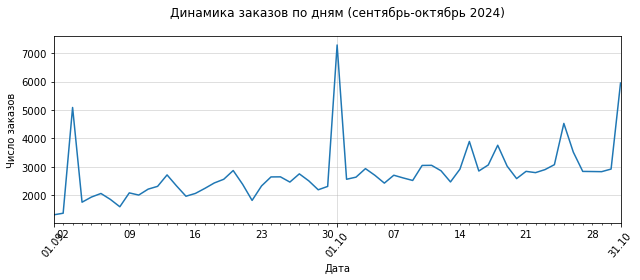

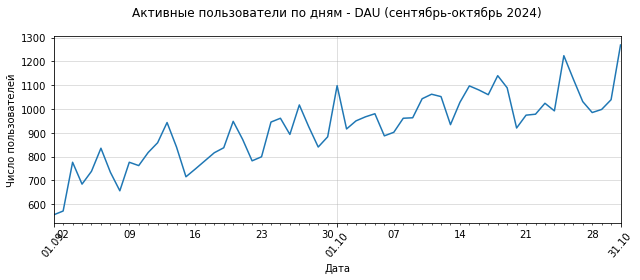

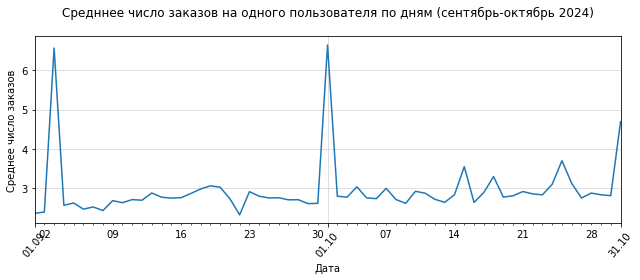

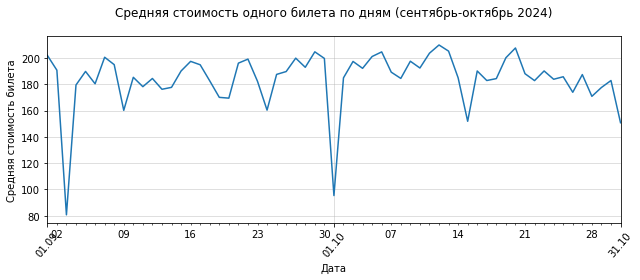

In [42]:
# Количество заказов 
# Создаем фигуру и размер, а также оси
fig,ax = plt.subplots(figsize=(9, 4))

# Визуализируем на линейном графике
summary_table_activity.plot(kind='line', x='created_dt_msk', y='total_orders', legend = False, 
                                                                        ax=ax) 
# Настраиваем оформление
ax.set_title('Динамика заказов по дням (сентябрь-октябрь 2024)', pad=20)
ax.set_ylabel('Число заказов')
ax.set_xlabel('Дата')
ax.grid(alpha=0.5)

# Форматируем даты на оси x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
plt.xticks(rotation=50)
plt.tight_layout()

# Выводим на экран
plt.show()

# DAU
# Создаем фигуру и размер, а также оси
fig,ax = plt.subplots(figsize=(9, 4))

# Визуализируем на линейном графике
summary_table_activity.plot(kind='line', x='created_dt_msk', y='dau', legend = False,
                                                                ax=ax) 
# Настраиваем оформление
ax.set_title('Активные пользователи по дням - DAU (сентябрь-октябрь 2024)', pad=20)
ax.set_ylabel('Число пользователей')
ax.set_xlabel('Дата')
ax.grid(alpha=0.5)

# Форматируем даты на оси x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
plt.xticks(rotation=50)
plt.tight_layout()

# Выводим на экран
plt.show()

# Средннее число заказов на одного пользователя 
# Создаем фигуру и размер, а также оси
fig,ax = plt.subplots(figsize=(9, 4))

# Визуализируем на линейном графике
summary_table_activity.plot(kind='line', x='created_dt_msk', y='avg_order_per_user', legend = False,
                                                                ax=ax) 
# Настраиваем оформление
ax.set_title('Средннее число заказов на одного пользователя по дням (сентябрь-октябрь 2024)', pad=20)
ax.set_ylabel('Среднее число заказов')
ax.set_xlabel('Дата')
ax.grid(alpha=0.5)

# Форматируем даты на оси x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
plt.xticks(rotation=50)
plt.tight_layout()

# Выводим на экран
plt.show()

# Средняя стоимость одного билета
# Создаем фигуру и размер, а также оси
fig,ax = plt.subplots(figsize=(9, 4))

# Визуализируем на линейном графике
summary_table_activity.plot(kind='line', x='created_dt_msk', y='avg_ticket_cost', legend = False,
                                                                ax=ax) 
# Настраиваем оформление
ax.set_title('Средняя стоимость одного билета по дням (сентябрь-октябрь 2024)', pad=20)
ax.set_ylabel('Средняя стоимость билета')
ax.set_xlabel('Дата')
ax.grid(alpha=0.5)

# Форматируем даты на оси x
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
plt.xticks(rotation=50)
plt.tight_layout()

# Выводим на экран
plt.show()

**Вывод.** Мы наблюдаем резкий рост общего числа заказов в следующие дни: 03.09 (5090 заказов) и 01.10 (7288 заказов) и 31.10 (5949 заказов) — вероятно, это запуск популярных мероприятий. В целом, видно что октябрь более активен, чем сентябрь. Конец октября демонстрирует сильный рост (25-31.10: от 2832 до 5949 заказов).

DAU колеблется между 555 (01.09.) до 1269 (31.10) пользователей. На графике заметен рост активных пользователей на протяжении всего периода, с небольшими колебаниями, это означает, что октябрь показывает более высокую активность (от 887 до 1269 пользователей), чем сентябрь (от 555 до 1017 пользователей).

Показатель среднего числа заказов на одного пользователя демонтрирует небольшие колебания ото дня ко дня (в среднем 2-3 заказа на пользователя), за исключением резких пиков -  03.09: 6.56 (рекордный показатель), 01.10: 6.64, 31.10: 4.69.

Показатель средней стоимости билета по дням показывает два резких минимума: 80.71 руб. (03.09) и 95.37 руб. (01.10). Вероятно с минимальной стоимостью билетов в эти дни связан всплеск числа заказов (03.09: 5090 заказов, 01.10: 7288), количества активных пользователей (01.10: 1098 пользователей) и числа заказов (03.09: 6.56, 01.10: 6.64). Также на графиках заметно, что чем дешевле билеты, тем больше продаж.

**Анализ недельной цикличности (сентябрь-октябрь 2024).**

Выделим день недели и сравним пользовательскую активность в будни и выходные.

In [43]:
# Преобразуем даты в названия дней недели
summary_table_activity['name_of_week'] = summary_table_activity['created_dt_msk'].dt.day_name()

# Создаем булев столбец (True для выходных, False для будней)
summary_table_activity['weekend_weekday'] = summary_table_activity['created_dt_msk'].dt.dayofweek >= 5

# Агрегируем данные по дням недели
weekly_cycle = summary_table_activity.groupby(['name_of_week', 'weekend_weekday']).agg({
    'total_orders': 'mean',
    'dau': 'mean',
    'avg_order_per_user': 'mean',
    'avg_ticket_cost': 'mean'}).reset_index()

# Упорядочим по дню недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_cycle['name_of_week'] = pd.Categorical(weekly_cycle['name_of_week'], categories=days_order, ordered=True)
weekly_cycle = weekly_cycle.sort_values('name_of_week')

display (weekly_cycle)

# Сравненим будни и выходные
weekend_comparison = summary_table_activity.groupby('weekend_weekday').agg({
    'total_orders': 'mean',
    'dau': 'mean',
    'avg_order_per_user': 'mean',
    'avg_ticket_cost': 'mean'}).reset_index()

display (f'Сравнение  будней (False) и выходных (True)')
display (weekend_comparison)

,name_of_week,weekend_weekday,total_orders,dau,avg_order_per_user,avg_ticket_cost
1,Monday,False,2385.888889,851.777778,2.780790,184.931926
5,Tuesday,False,3490.444444,933.000000,3.718898,157.113456
6,Wednesday,False,2536.888889,922.222222,2.748939,186.043228
4,Thursday,False,3008.000000,960.000000,3.060249,182.464119
0,Friday,False,3086.750000,1017.000000,3.001132,186.586722
2,Saturday,True,2649.625000,952.250000,2.767508,194.171872
3,Sunday,True,2136.111111,813.333333,2.605601,199.662963


'Сравнение  будней (False) и выходных (True)'

,weekend_weekday,total_orders,dau,avg_order_per_user,avg_ticket_cost
0,False,2897.386364,934.977273,3.063385,179.26519
1,True,2377.764706,878.705882,2.681792,197.07892


Визуализируем на линейных графиках динамику основных показателей по дням недели в осенний период.

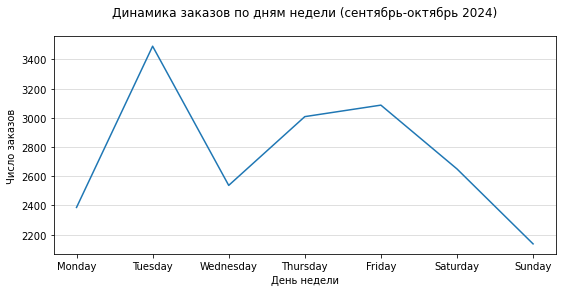

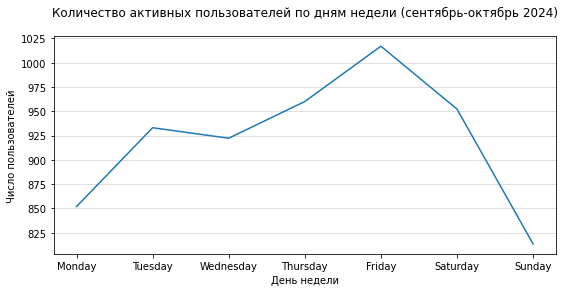

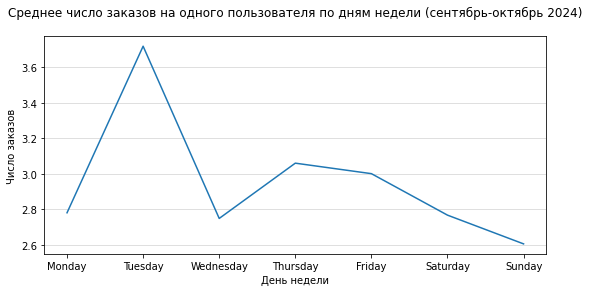

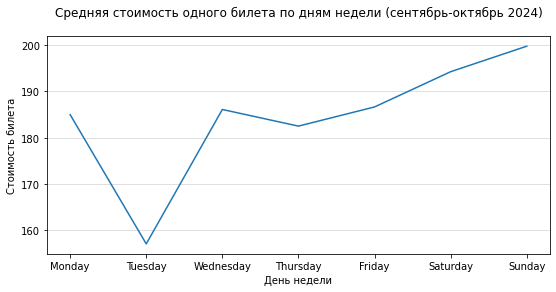

In [44]:
# Количество заказов по дням недели 
# Создаем фигуру и размер, а также оси
fig,ax = plt.subplots(figsize=(9, 4))

# Визуализируем на линейном графике
weekly_cycle.plot(kind='line', x='name_of_week', y='total_orders', legend = False, ax=ax) 

# Настраиваем оформление
ax.set_title('Динамика заказов по дням недели (сентябрь-октябрь 2024)', pad=20)
ax.set_ylabel('Число заказов')
ax.set_xlabel('День недели')
ax.yaxis.grid(alpha=0.5)

# Выводим на экран
plt.show()

# DAU по дням недели 
# Создаем фигуру и размер, а также оси
fig,ax = plt.subplots(figsize=(9, 4))

# Визуализируем на линейном графике
weekly_cycle.plot(kind='line', x='name_of_week', y='dau', legend = False, ax=ax) 

# Настраиваем оформление
ax.set_title('Количество активных пользователей по дням недели (сентябрь-октябрь 2024)', pad=20)
ax.set_ylabel('Число пользователей')
ax.set_xlabel('День недели')
ax.yaxis.grid(alpha=0.5)

# Выводим на экран
plt.show()

# Средннее число заказов на одного пользователя по дням недели 
# Создаем фигуру и размер, а также оси
fig,ax = plt.subplots(figsize=(9, 4))

# Визуализируем на линейном графике
weekly_cycle.plot(kind='line', x='name_of_week', y='avg_order_per_user', legend = False, ax=ax) 

# Настраиваем оформление
ax.set_title('Среднее число заказов на одного пользователя по дням недели (сентябрь-октябрь 2024)', pad=20)
ax.set_ylabel('Число заказов')
ax.set_xlabel('День недели')
ax.yaxis.grid(alpha=0.5)

# Выводим на экран
plt.show()

# Средняя стоимость одного билета по дням недели 
# Создаем фигуру и размер, а также оси
fig,ax = plt.subplots(figsize=(9, 4))

# Визуализируем на линейном графике
weekly_cycle.plot(kind='line', x='name_of_week', y='avg_ticket_cost', legend = False, ax=ax) 

# Настраиваем оформление
ax.set_title('Средняя стоимость одного билета по дням недели (сентябрь-октябрь 2024)', pad=20)
ax.set_ylabel('Стоимость билета')
ax.set_xlabel('День недели')
ax.yaxis.grid(alpha=0.5)

# Выводим на экран
plt.show()

**Вывод.** По количеству заказов мы наблюдаем, что в будни данный показатель выше: максимум во вторник (3490 заказов) и пятница (3087 заказов) — всплеск перед выходными. Выходные проседают: в воскресенье — минимум (2136 заказов, на 39% меньше вторника), суббота по активности ближе к будням (2649 заказов).

В поведении пользователей можно также отметить, что будни активнее: пиковый рост происходти в пятницу - 1017, а минимальное число активных пользователей приходится на воскресенье - 813.

Среднее число заказов на одного пользователя выше в будни: максимум вторник - 3.7, минимум - воскресенье 2.6.

По средней стоимости билетов лидируют выходные: суббота 199.66 руб. и воскресенье 194.17 руб. Во вторник самый низкий уровень стоимости 157.11 руб. — вероятно, это акционный день, так как в этот же день наблюдается максимальное количество заказов (3490) и рекордное среднее число заказов на одного пользователя (3.7).

Из всего вышеперечисленного можно заключить, что активность пользователей ниже в выходные дни, и в этот же период выше средний чек.

**Популярные события и партнёры.**

**Популярные регионы по уникальному количеству мероприятий и общему числу заказов.**

Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов.

In [45]:
# Показатели по регионам
region_stats = autumn_afisha.groupby('region_name').agg(
    unique_events_autumn=('event_id', 'nunique'),
    total_orders_autumn=('order_id', 'count'),
    ).sort_values('unique_events_autumn', ascending=False).reset_index()

# Добавляем доли
region_stats['events_share'] = (region_stats['unique_events_autumn'
                                            ] / region_stats['unique_events_autumn'].sum() * 100).round(2)
region_stats['orders_share'] = (region_stats['total_orders_autumn'
                                           ] / region_stats['total_orders_autumn'].sum() * 100).round(2)

display (region_stats.head(10))

,region_name,unique_events_autumn,total_orders_autumn,events_share,orders_share
0,Каменевский регион,3894,46578,24.68,27.74
1,Североярская область,2597,20626,16.46,12.28
2,Широковская область,794,8645,5.03,5.15
3,Светополянский округ,755,4752,4.79,2.83
4,Речиновская область,529,3565,3.35,2.12
5,Серебринская область,456,4467,2.89,2.66
6,Яблоневская область,431,4196,2.73,2.50
7,Тепляковская область,419,2485,2.66,1.48
8,Горицветская область,406,3230,2.57,1.92
9,Солнечноземская область,401,4193,2.54,2.50


Визуализируем топ-10 регионов по количеству уникальных мероприятий и заказов, а также распределение долей мероприятий по регионам.

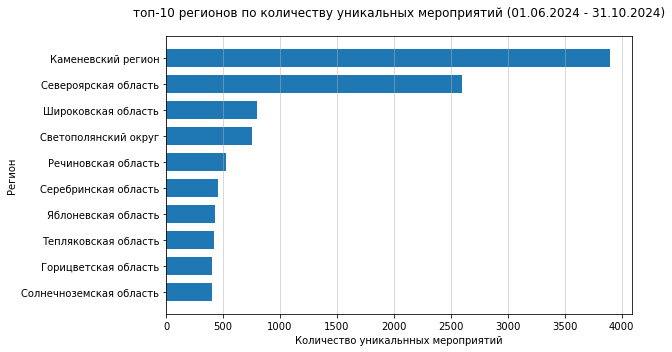

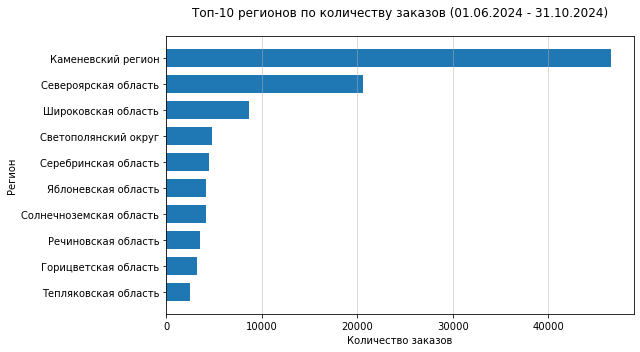

In [46]:
# Визуализируем топ-10 регионов по количеству уникальных мероприятий
# Задаем размер графика
plt.figure(figsize=(9, 5))

top_regions_events = region_stats.head(10).sort_values('unique_events_autumn', ascending=True)

# Строим горизонтальную диаграмму
plt.barh(top_regions_events['region_name'],
    top_regions_events['unique_events_autumn'], height=0.7)
 
# Настраиваем внешний вид диаграммы
plt.title('топ-10 регионов по количеству уникальных мероприятий (01.06.2024 - 31.10.2024)', pad=20)
plt.xlabel('Количество уникальнных мероприятий')
plt.ylabel('Регион')
plt.grid(axis='x', alpha=0.6)

plt.tight_layout()
plt.show()

# Визуализируем топ-10 регионов по количеству заказов
# Задаем размер графика
plt.figure(figsize=(9, 5))

top_regions_orders = region_stats.head(10).sort_values('total_orders_autumn', ascending=True)

# Строим горизонтальную диаграмму
plt.barh(top_regions_orders['region_name'],
    top_regions_orders['total_orders_autumn'], height=0.7)
 
# Настраиваем внешний вид диаграммы
plt.title('Топ-10 регионов по количеству заказов (01.06.2024 - 31.10.2024)', pad=20)
plt.xlabel('Количество заказов')
plt.ylabel('Регион')
plt.grid(axis='x', alpha=0.6)

plt.tight_layout()
plt.show()

count     79.000000
mean       1.265823
median     0.370000
std        3.366640
min        0.010000
max       24.680000
Name: events_share, dtype: float64

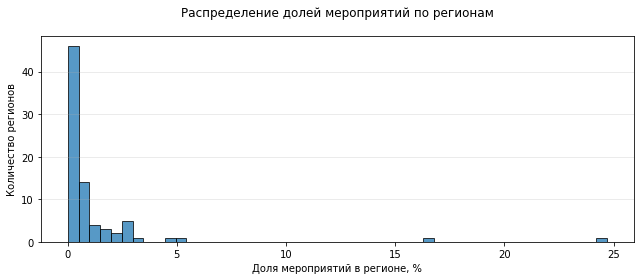

count     79.000000
mean       1.266329
median     0.330000
std        3.502339
min        0.010000
max       27.740000
Name: orders_share, dtype: float64

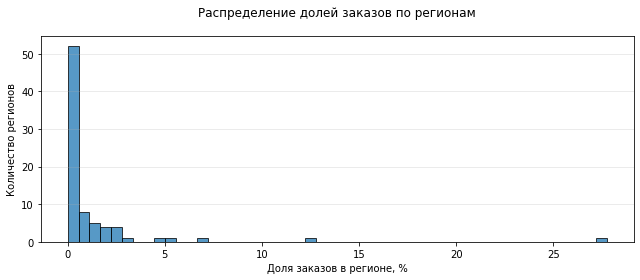

In [47]:
# Статистика столбца с долями уникальных событий по регионам 
display(region_stats['events_share'].agg(['count','mean','median','std',
                                                    'min','max']))

# Строим гистограмму 
region_stats['events_share'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=50, # Устанавливаем количество корзин
                alpha=0.75,# Устанавливаем частичную прозрачность
                edgecolor= 'black', # Устанавливаем цвет границ ячеек гистограммы
                figsize=(9, 4))

# Настраиваем оформление
plt.title('Распределение долей мероприятий по регионам', pad=20)
plt.xlabel('Доля мероприятий в регионе, %')
plt.ylabel('Количество регионов')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика столбца с долями заказов по регионам 
display(region_stats['orders_share'].agg(['count','mean','median','std',
                                                    'min','max']))

# Строим гистограмму 
region_stats['orders_share'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=50, # Устанавливаем количество корзин
                alpha=0.75,# Устанавливаем частичную прозрачность
                edgecolor= 'black', # Устанавливаем цвет границ ячеек гистограммы
                figsize=(9, 4))

# Настраиваем оформление
plt.title('Распределение долей заказов по регионам', pad=20)
plt.xlabel('Доля заказов в регионе, %')
plt.ylabel('Количество регионов')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Вывод по популярным регионам.** Мы видим, что Каменевский регион является абсолютным лидером по всем показателям: уникальные события 3894 - доля от общего числа 24.68%, заказы 46578 - доля от общего числа 27.74%. Североярская область занимает второе место: 16.46% мероприятий (2597) и 12.28% заказов (20626). Остальные регионы из топ-10 вносят значительно меньший вклад (события от 2.54% до 5.03%, заказы от 2.50% до 5.15%).

Анализ общего распределения по статистике долей показывает сильную асимметрию: средняя доля мероприятий: 1.27%, но медиана всего 0.37%, средняя доля заказов: 1.27%, медиана 0.33%, говорит о наличии сильный выбросов в большую сторону. Это подтверждает, что существенно преобладает количество незначительных долей.

**Популярные партнёры по уникальному количеству мероприятий, обработанным заказам и суммарной выручке с заказов билетов.**

Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. 


In [48]:
# Показатели по по партнёрам
partner_stats = autumn_afisha.groupby('service_name').agg(
    unique_events_partner=('event_id', 'nunique'),
    total_orders_partner=('order_id', 'count'),
    total_revenue_partner=('revenue_rub', 'sum')
).sort_values('unique_events_partner', ascending=False).reset_index()

# Добавляем доли
partner_stats['events_share_partner'] = (partner_stats['unique_events_partner'
                                                     ] / partner_stats['unique_events_partner'].sum() * 100).round(2)
partner_stats['orders_share_partner'] = (partner_stats['total_orders_partner'
                                                     ] / partner_stats['total_orders_partner'].sum() * 100).round(2)
partner_stats['revenue_share_partner'] = (partner_stats['total_revenue_partner'
                                                      ] / partner_stats['total_revenue_partner'].sum() * 100).round(2)
display(partner_stats.head(10))

,service_name,unique_events_partner,total_orders_partner,total_revenue_partner,events_share_partner,orders_share_partner,revenue_share_partner
0,Лови билет!,3584,25710,1.038454e+07,20.84,15.31,12.68
1,Билеты без проблем,2821,32028,1.217264e+07,16.40,19.07,14.86
2,Билеты в руки,2447,25544,7.614422e+06,14.23,15.21,9.30
3,Облачко,1409,15478,1.061105e+07,8.19,9.22,12.96
4,Лучшие билеты,1377,12349,1.676034e+06,8.01,7.35,2.05
5,Мой билет,1006,19419,1.085081e+07,5.85,11.57,13.25
6,Тебе билет!,858,3759,2.166185e+06,4.99,2.24,2.64
7,Прачечная,728,5798,2.548310e+06,4.23,3.45,3.11
8,Весь в билетах,600,9418,9.356427e+06,3.49,5.61,11.42
9,Яблоко,537,3473,2.763332e+06,3.12,2.07,3.37


Визуализируем топ-10 билетных партнёров по количеству уникальных мероприятий, заказов и суммарной выручки с заказов билетов. 

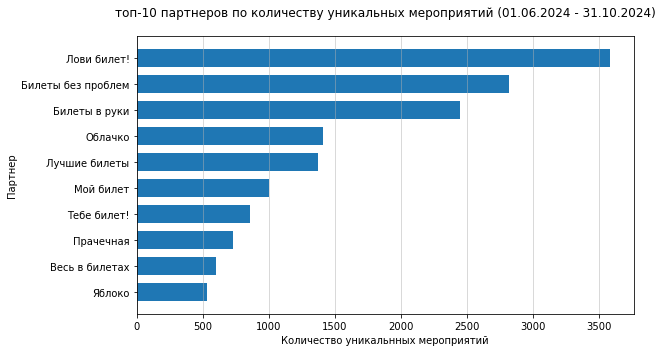

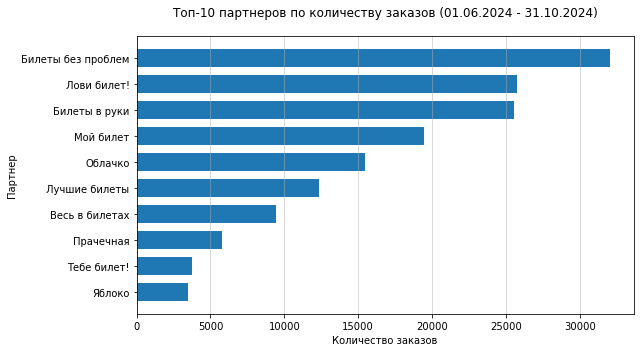

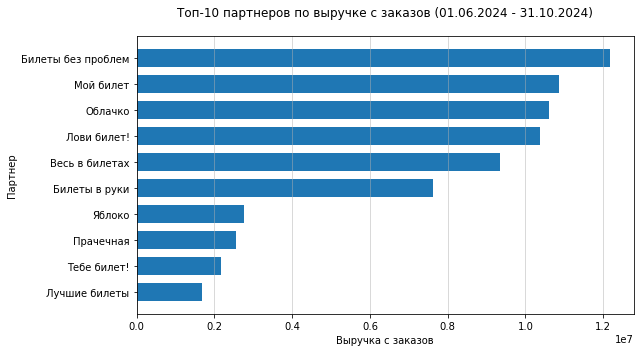

In [49]:
# Визуализируем топ-10 партнеров по количеству уникальных мероприятий
# Задаем размер графика
plt.figure(figsize=(9, 5))

top_partner_events = partner_stats.head(10).sort_values('unique_events_partner', ascending=True)

# Строим горизонтальную диаграмму
plt.barh(top_partner_events['service_name'],
    top_partner_events['unique_events_partner'], height=0.7)
 
# Настраиваем внешний вид диаграммы
plt.title('топ-10 партнеров по количеству уникальных мероприятий (01.06.2024 - 31.10.2024)', pad=20)
plt.xlabel('Количество уникальнных мероприятий')
plt.ylabel('Партнер')
plt.grid(axis='x', alpha=0.6)

plt.tight_layout()
plt.show()

# Визуализируем топ-10 партнеров по количеству заказов
# Задаем размер графика
plt.figure(figsize=(9, 5))

top_partner_orders = partner_stats.head(10).sort_values('total_orders_partner', ascending=True)

# Строим горизонтальную диаграмму
plt.barh(top_partner_orders['service_name'],
    top_partner_orders['total_orders_partner'], height=0.7)
 
# Настраиваем внешний вид диаграммы
plt.title('Топ-10 партнеров по количеству заказов (01.06.2024 - 31.10.2024)', pad=20)
plt.xlabel('Количество заказов')
plt.ylabel('Партнер')
plt.grid(axis='x', alpha=0.6)

plt.tight_layout()
plt.show()

# Визуализируем топ-10 партнеров по выручки с заказов
# Задаем размер графика
plt.figure(figsize=(9, 5))

top_partner_revenue = partner_stats.head(10).sort_values('total_revenue_partner', ascending=True)

# Строим горизонтальную диаграмму
plt.barh(top_partner_revenue['service_name'],
    top_partner_revenue['total_revenue_partner'], height=0.7)
 
# Настраиваем внешний вид диаграммы
plt.title('Топ-10 партнеров по выручке с заказов (01.06.2024 - 31.10.2024)', pad=20)
plt.xlabel('Выручка с заказов')
plt.ylabel('Партнер')
plt.grid(axis='x', alpha=0.6)

plt.tight_layout()
plt.show()

count     35.000000
mean       2.857143
median     0.760000
std        5.032592
min        0.010000
max       20.840000
Name: events_share_partner, dtype: float64

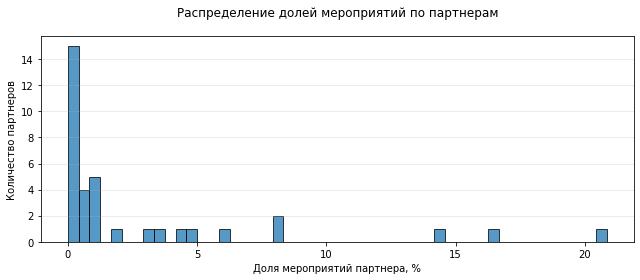

count     35.000000
mean       2.856571
median     0.550000
std        5.081042
min        0.000000
max       19.070000
Name: orders_share_partner, dtype: float64

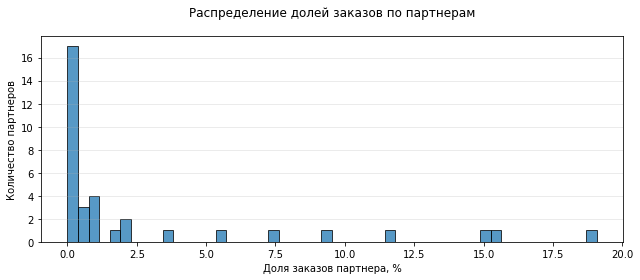

count     35.000000
mean       2.857429
median     0.740000
std        4.584384
min        0.000000
max       14.860000
Name: revenue_share_partner, dtype: float64

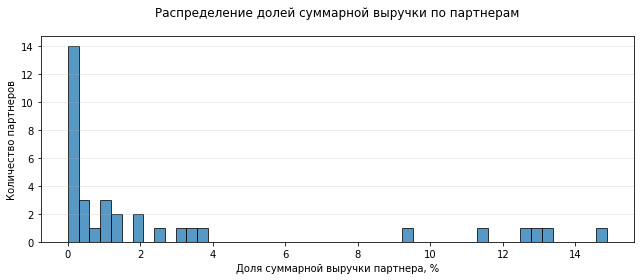

In [50]:
# Статистика столбца с долями уникальных событий по партнёрам
display(partner_stats['events_share_partner'].agg(['count','mean','median','std',
                                                    'min','max']))

# Строим гистограмму 
partner_stats['events_share_partner'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=50, # Устанавливаем количество корзин
                alpha=0.75,# Устанавливаем частичную прозрачность
                edgecolor= 'black', # Устанавливаем цвет границ ячеек гистограммы
                figsize=(9, 4))

# Настраиваем оформление
plt.title('Распределение долей мероприятий по партнерам', pad=20)
plt.xlabel('Доля мероприятий партнера, %')
plt.ylabel('Количество партнеров')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика столбца с долями заказов по партнерам
display(partner_stats['orders_share_partner'].agg(['count','mean','median','std',
                                                    'min','max']))

# Строим гистограмму 
partner_stats['orders_share_partner'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=50, # Устанавливаем количество корзин
                alpha=0.75,# Устанавливаем частичную прозрачность
                edgecolor= 'black', # Устанавливаем цвет границ ячеек гистограммы
                figsize=(9, 4))

# Настраиваем оформление
plt.title('Распределение долей заказов по партнерам', pad=20)
plt.xlabel('Доля заказов партнера, %')
plt.ylabel('Количество партнеров')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# Статистика столбца с долями суммарной выручки по партнерам
display(partner_stats['revenue_share_partner'].agg(['count','mean','median','std',
                                                    'min','max']))

# Строим гистограмму 
partner_stats['revenue_share_partner'].plot(
                kind='hist', # Тип графика - гистограмма
                bins=50, # Устанавливаем количество корзин
                alpha=0.75,# Устанавливаем частичную прозрачность
                edgecolor= 'black', # Устанавливаем цвет границ ячеек гистограммы
                figsize=(9, 4))

# Настраиваем оформление
plt.title('Распределение долей суммарной выручки по партнерам', pad=20)
plt.xlabel('Доля суммарной выручки партнера, %')
plt.ylabel('Количество партнеров')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Вывод по популярным партнёрам.** Можно заметить, что топ-3 партнёра контролируют 51.5% всех мероприятий (Лови билет! 20.8% + Билеты без проблем 16.4% + Билеты в руки 14.2%) и 49.6% всех заказов (Лови билет! 15.3% + Билеты без проблем 19.1% + Билеты в руки 15.2%). Партнёр "Лови билет!" лидирует по мероприятиям (20.8%), тогда как "Билеты без проблем" доминирует по заказам (19.1%) и выручке (14.9%).

Некоторые операторы из топ-10 демонстрируют высокую эффективность по выручке:
- "Мой билет" - при 5.9% мероприятий и 11.6% заказов генерирует 13.3% выручки,
- "Весь в билетах" - при 3.5% мероприятий и 5.6% заказов генерирует 11.4% выручки,
- "Облачко" - при 8.2% мероприятий и 9.2% заказов генерирует 13.0% выручки,

что может указывать на работу с премиальными событиями. 

"Лучшие билеты" показывает обратную ситуацию - низкую маржинальность (при 8.0% мероприятий и 7.4% заказов - 2.1% выручки).

В целом, распределение долей по всем показателям показывает сильную концентрацию небольших значений с сильными выбросами в большую сторону - медианные значения  (0.55-0.76%) значительно ниже средних (2.86%).

## Статистический анализ данных.

**Проверка гипотез.**

Проверим две гипотезы, которые предполагают большую активность пользователей мобильных устройств.

`1 Гипотеза`. Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- H0: Среднее количество заказов у мобильных и десктопных пользователей одинаково.
- H1: Среднее количество заказов у мобильных пользователей выше.

Перед применением t-теста убедимся, что данные удовлетворяют следующим условиям:
- Независимость выборок - проверим пересечение по пользователям в двух группах.
- Равенство размера выборок - посчитаем количество уникальных пользователей в обоих группах.
- Нормальность распределения - проверим графическим методом, с помощью `Q-Q plot`.
- Однородность дисперсий - проведем тест `Тест Левена`.

Разделяем пользователей по типу устройства.

In [51]:
#  Разделяем пользователей по типу устройства
mobile_users = df_afisha[df_afisha['device_type_canonical'] == 'mobile']
desktop_users = df_afisha[df_afisha['device_type_canonical'] == 'desktop']

Проверяем пользователей на пересечения в выборках.

In [52]:
# Получаем уникальные user_id для каждой группы
mobile_user_id = set(mobile_users['user_id'].unique())
desktop_user_id = set(desktop_users['user_id'].unique())

# Находим пересечения
intersections_users = mobile_user_id & desktop_user_id
num_intersections_users = len(intersections_users)

display(f"Количество пользователей, использующих оба типа устройств: {num_intersections_users}")

'Количество пользователей, использующих оба типа устройств: 4904'

Обнаружено 4904 пользователя, использующих оба типа устройств. Удалим их для корректного проведения теста.

In [53]:
mobile_users_clean = mobile_users[~mobile_users['user_id'].isin(intersections_users)]
desktop_users_clean = desktop_users[~desktop_users['user_id'].isin(intersections_users)]

Оценим, можно ли применять t-тест при текущем соотношении выборок.

In [54]:
# Считаем количество уникальных пользователей в группах 
count_mobile =mobile_users_clean['user_id'].nunique()
count_desktop = desktop_users_clean['user_id'].nunique()

# Считаем соотношение
ratio = max(count_mobile, count_desktop) / min(count_mobile, count_desktop)

display(f"Мобильные пользователи: {count_mobile}")
display(f"Десктопные пользователи: {count_desktop}")
display(f"Соотношение: {ratio:.2f}:1")

'Мобильные пользователи: 14660'

'Десктопные пользователи: 2127'

'Соотношение: 6.89:1'

Количество уникальных пользователей в мобильной группе больше в 6.89 раз по сравнению с десктопной. В данном случае, будет правильнее использовать тест Уэлча, так как он устойчив к неравным размерам выборок.

Определим нормальность распределения, чтобы понять можно ли использовать параметрический тест. Используем график `Q-Q plot`, который сравнивает квантили данных с квантилями теоретического нормального распределения. Если данные нормальны, точки будут лежать на прямой линии. Отклонения от линии указывают на ненормальность.

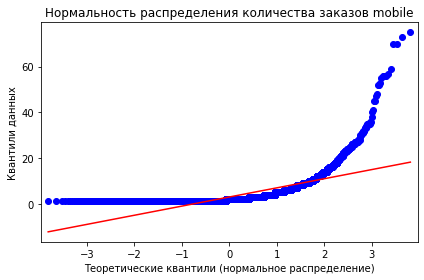

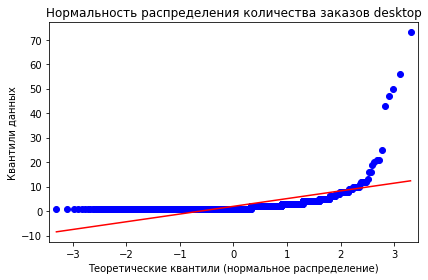

In [62]:
import warnings  
warnings.filterwarnings("ignore", category=UserWarning)  

# Считаем количество заказов на пользователя
mobile_orders = mobile_users_clean.groupby('user_id')['order_id'].count()
desktop_orders = desktop_users_clean.groupby('user_id')['order_id'].count()

# Q-Q plot для мобильных пользователей
sm.qqplot(mobile_orders, line='s')  # 's' - линия нормального распределения
plt.title('Нормальность распределения количества заказов mobile')
plt.xlabel('Теоретические квантили (нормальное распределение)')  
plt.ylabel('Квантили данных')  

plt.tight_layout()
plt.show()

# Q-Q plot для десктопных пользователей
sm.qqplot(desktop_orders, line='s')
plt.title('Нормальность распределения количества заказов desktop')
plt.xlabel('Теоретические квантили (нормальное распределение)')  
plt.ylabel('Квантили данных')  

plt.tight_layout()
plt.show()

Поскольку данные распределены не нормально (точки образуют кривую, отклонены от нормальной прямой), использовать параметрические тесты (t-тест или тест Уэлча) не корректно. В данном случае, применим аналог t-теста — `тест Манна-Уитни`. Так как он не опирается на параметры распределения, условие о равенства дисперсий проверять не будем.

Установим уровень значимости `α = 0.05`, это стандартный порог в статистике при проверке продуктовых гипотез.

In [56]:
# Задаем уровень значимости
alpha = 0.05  

# Проводим тест Манна-Уитни с альтернативной гипотезой "мобильные > десктопные"
result = mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')

display('p-значение:', result.pvalue)

if result.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'p-значение:'

2.1008065197213923e-54

'Отвергаем нулевую гипотезу'

**Вывод.** Полученное `p-значение` (2.1e-54) существенно меньше заданного уровня значимости 0.05, это означает, что мы не можем  принять нулевую гипотезу о том, что среднее количество заказов у мобильных и десктопных пользователей одинаково.

По результату `p-value` (2.1e-54), мы видим, что значение очень мало, отсюда можно заключить, что статистический анализ показал, что мобильные пользователи Яндекс Афиши с высокой вероятностью совершают значительно больше заказов, чем пользователи десктопной версии.

`2 Гипотеза`. Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.
- H0: Время между заказами одинаково для мобильных и десктопных пользователей.
- H1: Время между заказами у мобильных пользователей больше.

Создадим столбец с количеством дней между заказами пользователей. Будем работать с датафреймами `mobile_users_clean` и 
`desktop_users_clean`, так как в них нет пересечений по пользователям.

In [57]:
# Для mobile
# Сортируем данные по пользователю и дате заказа
df_sort_mobile = mobile_users_clean.sort_values(['user_id', 'created_dt_msk'])

# Создаем столбец с датой предыдущего заказа для каждого пользователя
df_sort_mobile['date_previous order'] = df_sort_mobile.groupby('user_id')['created_dt_msk'].shift(1)

# Рассчитываем разницу в днях между текущим и предыдущим заказом
df_sort_mobile['number_days_between_orders'] = (df_sort_mobile['created_dt_msk'] - df_sort_mobile['date_previous order'
                                                                                                 ]).dt.days

# Для desktop
# Сортируем данные по пользователю и дате заказа
df_sort_desktop = desktop_users_clean.sort_values(['user_id', 'created_dt_msk'])

# Создаем столбец с датой предыдущего заказа для каждого пользователя
df_sort_desktop['date_previous order'] = df_sort_desktop.groupby('user_id')['created_dt_msk'].shift(1)

# Рассчитываем разницу в днях между текущим и предыдущим заказом
df_sort_desktop['number_days_between_orders'] = (df_sort_desktop['created_dt_msk'] - df_sort_desktop['date_previous order'
                                                                                                 ]).dt.days

Проверим результат, возьмем первых трёх пользователей.

In [58]:
# Проверяем результат
sample_users_mobile = df_sort_mobile['user_id'].unique()[:3]  # Первые 3 пользователя
display(df_sort_mobile[df_sort_mobile['user_id'].isin(sample_users_mobile)][['user_id', 'created_dt_msk', 
                                                                             'date_previous order', 
                                                                           'number_days_between_orders',
                                                                            'device_type_canonical']])


sample_users_desktop = df_sort_desktop['user_id'].unique()[:5]  # Первые 3 пользователя
display(df_sort_desktop[df_sort_desktop['user_id'].isin(sample_users_desktop)][['user_id', 'created_dt_msk', 
                                                                             'date_previous order', 
                                                                           'number_days_between_orders',
                                                                            'device_type_canonical']])

,user_id,created_dt_msk,date_previous order,number_days_between_orders,device_type_canonical
0,0002849b70a3ce2,2024-08-20,NaT,NaN,mobile
1,0005ca5e93f2cf4,2024-07-23,NaT,NaN,mobile
2,0005ca5e93f2cf4,2024-10-06,2024-07-23,75.0,mobile
3,000898990054619,2024-07-13,NaT,NaN,mobile
4,000898990054619,2024-10-04,2024-07-13,83.0,mobile
5,000898990054619,2024-10-23,2024-10-04,19.0,mobile


,user_id,created_dt_msk,date_previous order,number_days_between_orders,device_type_canonical
6,00096d1f542ab2b,2024-08-15,NaT,NaN,desktop
81,003904af842c08b,2024-07-11,NaT,NaN,desktop
131,00886701a39bd5c,2024-07-03,NaT,NaN,desktop
209,00bdfa36a6e542b,2024-10-17,NaT,NaN,desktop
217,00cb8c1ef996876,2024-10-21,NaT,NaN,desktop
218,00cb8c1ef996876,2024-10-22,2024-10-21,1.0,desktop


Столбцы успешно добавлены, далее отфильтруем в поле `number_days_between_orders` значения `NaN` - удалим пользователей у которых один заказ и рассчитаем среднее значение времени между заказами по пользователям.

In [59]:
# Фильтруем пользователей с >1 заказа (иначе number_days_between_orders = NaN)
mobile_interval = df_sort_mobile.groupby('user_id')['number_days_between_orders'].mean().dropna()
desktop_interval = df_sort_desktop.groupby('user_id')['number_days_between_orders'].mean().dropna()

Выше мы проверили данные на пересечения пользователей в выборках и устранили их. Теперь определим нормальность распределения и если это условие выполняется, то проверим однородноть дисперсий и проведем t-тест Уэлча. В обратном случае, тест Манна-Уитни.

Проверим нормальность распределения в столбце `number_days_between_orders` - количество дней между заказами пользователей в мобильной и десктопной версиях. 

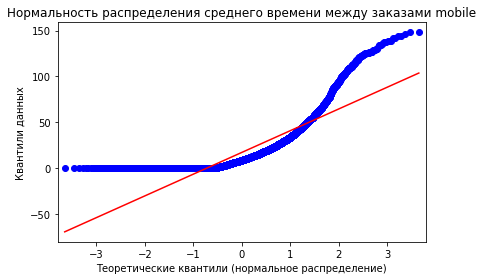

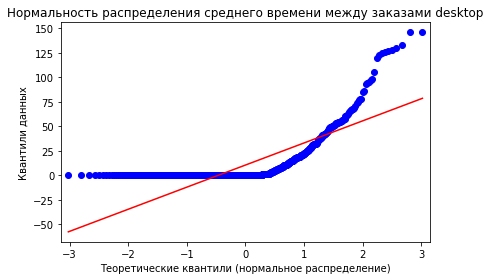

In [63]:
mobile_interv = mobile_interval.reset_index()
desktop_interv = desktop_interval.reset_index()

# Q-Q plot для мобильных пользователей
sm.qqplot(mobile_interv['number_days_between_orders'], line='s') # 's' - линия нормального распределения
plt.title('Нормальность распределения среднего времени между заказами mobile')
plt.xlabel('Теоретические квантили (нормальное распределение)')  
plt.ylabel('Квантили данных')  

plt.tight_layout()
plt.show()

# Q-Q plot для десктопных пользователей
sm.qqplot(desktop_interv['number_days_between_orders'], line='s') # 's' - линия нормального распределения
plt.title('Нормальность распределения среднего времени между заказами desktop')
plt.xlabel('Теоретические квантили (нормальное распределение)')  
plt.ylabel('Квантили данных')  

plt.tight_layout()
plt.show()

Данные распределены не нормально, будем использовать непараметрические `тест Манна-Уитни`. Так как он не опирается на параметры распределения, условие о равенства дисперсий проверять не будем.

Установим уровень значимости `α = 0.05`.

In [64]:
# Задаем уровень значимости
alpha = 0.05  

# Проводим тест Манна-Уитни с альтернативной гипотезой "мобильные > десктопные"
result = mannwhitneyu(mobile_interval, desktop_interval, alternative='greater')

display('p-значение:', result.pvalue)

if result.pvalue < alpha:
    display('Отвергаем нулевую гипотезу')
else:
    display('Не получилось отвергнуть нулевую гипотезу')

'p-значение:'

2.7993568503523486e-48

'Отвергаем нулевую гипотезу'

**Вывод.** Полученный результат `p-значение` (2.8e-48) значительно меньше заданного уровня значимости (0.05). Мы отвергаем нулевую гипотезу и можем сделать вывод, что значимость полученного результата статистически высока. Это означает, что разница не случайна, а обусловлена реальными поведенческими различиями между платформами - мобильные клиенты делают повторные заказы реже, чем пользователи на компьютерах.

## Общий вывод и рекомендации.
Был проведен исследовательский анализ данных о 281906 заказах сервиса `Яндекс Афиша` с 01.06.2024 по 31.10.2024 год. После предобработки данных и подготовки их к исследованию было удалено 8943 строки из 281906 - это 3.17%. Основная информация, которую содержит датасет - это данные о типах мероприятий, устройствах пользователей (мобильные/десктоп), географии (регионы), партнерах и выручке от заказов билетов. 
Из проведенного анализа можно заключить следующее:
- Летом лидируют концерты (43.9%), осенью данный тип мероприятия сохраняет лидерство, но доля снижается (37.4%), и набирают популярность театры (25.4%) и спорт (11.2%).
- Средний чек осенью упал для театров (-18.6%), концертов (-13.4%), но вырос для выставок (+5.9%) и стендапов (5.77%).
- Мобильные устройства доминируют (летом 80.9%, осенью 79.6%), но осенью также растут десктоп-покупки (+1.3 п.п.), вероятно это покупка групповых билетов.
- Семейные мероприятия (0+), осенью становятся популярнее (+5.3 п.п.) -  летом 18.1%, осенью 23.4%, а на 18+ снижается спрос - 13.9% летом, 10.4% осенью.

В целом, осенний период показывает значительный рост активности по сравнению с летними месяцами - наблюдается пик заказов в октябре (99 013), что в 3 раза выше, чем в июне (32 933). Осенью, резкий рост общего числа заказов происходит в следующие дни: 03.09 (5090 заказов) и 01.10 (7288 заказов) и 31.10 (5949 заказов). Также анализ активности осеннего периода показал, что будни (особенно вторник и пятница) лидируют по количеству заказов (вторник +39% к воскресенью) и числу активных пользователей (максимальное значение DAU 1017 в пятницу), а выходные демонстрируют более высокий средний чек (максимум 200 руб. в субботу, минимум 157 руб. во вторник).

Среди регионов можно отметить абсолютного лидера `Каменевский регион` (24.7% мероприятий, 27.7% заказов), на втором месте `Североярская область` (16.5% мероприятий 12.3% заказов). Доли по количеству событий и заказов среди остальных регионов невысоки (события от 2.54% до 5.03%, заказы от 2.50% до 5.15%).

По партнерам можно выделить следующих билетных операторов: `Лови билет!` (максимум мероприятий 20.8%), `Билеты без проблем` (максимум заказов 19.1% и выручки 14.9). Партнёры `Мой билет` (при 5.9% мероприятий, 11.6% заказов - 13.3% выручки), `Весь в билетах` (при 3.5% мероприятий, 5.6% заказов -  11.4% выручки) и `Облачко` (при 8.2% мероприятий, 9.2% заказов - 13.0% выручки), показывают высокую эффективность по выручке.

Была проведена проверка двух гипотез:
1. - H0: Среднее количество заказов у мобильных и десктопных пользователей одинаково.
   - H1: Среднее количество заказов у мобильных пользователей выше.
   
Для проверки гипотезы выбрали непараметрический тест Манна-Уитни, (так как данные не отвечают условию о нормальности), с уровнем значимости 0.05 – это стандартное значение для проверки продуктовых гипотез.

По результату теста значение `p-value` = 2.1e⁻⁵⁴, что значительно меньше заданного уровня значимости (0.05). Это означает, что мы не можем принять нулевую гипотезу о том, что среднее количество заказов у мобильных и десктопных пользователей одинаково.

2. - H0: Время между заказами одинаково для мобильных и десктопных пользователей.
   - H1: Время между заказами у мобильных пользователей больше.
   
Для проверки данной гипотезы, также был выбран тест Манна-Уитни, (данные не отвечают условию о нормальности) и уровень значимости 0.05. Мы получили `p-value` = 2.8e⁻⁴⁸, что существенно ниже уровня значимости (0.05). Это говорит о том, что мы не принимаем нулевую гипотезу о том, что время между заказами одинаково для мобильных и десктопных пользователей.

В обоих гипотезах, значения `p-value` ничтожно малы, это указывает на то, что значимость полученного результата статистически высока.

По результатам проведенного анализа, в качестве рекомендаций, стоит обратить внимание на приоритетные направления:
- усилить маркетинг для мобильных пользователей (доля летом 80.9%, осенью 79.6%), например, оптимизировать быстрый заказ в приложении,
- развивать премиальные мероприятия: партнеры `Мой билет` (при 5.9% мероприятий, 11.6% заказов - 13.3% выручки), `Весь в билетах` (при 3.5% мероприятий, 5.6% заказов -  11.4% выручки) и `Облачко` (при 8.2% мероприятий, 9.2% заказов - 13.0% выручки) показывают высокую маржинальность.

Также, мы видим, что осенью набирают популярность театры (доля осенью 25.4%, летом 20.8%) и спортивные события (доля осенью 11.2%, летом 2.4%) –  стоит увеличить ассортимент на данный тип мероприятий в осенний сезон.